<a href="https://colab.research.google.com/github/itaborai83/eleicoes2022/blob/main/DataViz_Elei%C3%A7%C3%B5es_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Domínio de Interesse

In [93]:
!pip install matplotlib numpy pandas requests basemap pyarrow pyshp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [94]:
import math
import os.path
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from matplotlib.scale import LogScale
import requests
import shutil
import scipy.signal as signal
from mpl_toolkits.basemap import Basemap
import shapefile
from collections import defaultdict

In [95]:
# Criação dos diretórios de dados
!mkdir -p DATA
!mkdir -p DATA/GIS

# arquivo de resultados da eleição de 2022
# !wget -nc -O DATA/votacao_secao_2022_BR.zip https://cdn.tse.jus.br/estatistica/sead/odsele/votacao_secao/votacao_secao_2022_BR.zip
!wget -nc -O DATA/votacao_secao_2022_BR.zip https://itaborai83-eleicoes2022.s3.sa-east-1.amazonaws.com/votacao_secao_2022_BR.zip

# arquivo de resultado da eleição de 2018
# !wget -nc -O DATA/votacao_secao_2018_BR.zip https://cdn.tse.jus.br/estatistica/sead/odsele/votacao_secao/votacao_secao_2018_BR.zip
!wget -nc -O DATA/votacao_secao_2018_BR.zip https://itaborai83-eleicoes2022.s3.sa-east-1.amazonaws.com/votacao_secao_2018_BR.zip

# arquivo com coordenadas geocodificadas das seções eleitorais. Arquivo original possuía cerca de 1/3 de dados não geocodificados
# !wget -nc -O DATA/eleitorado.parquet https://github.com/itaborai83/eleicoes2022/blob/main/eleitorado.parquet?raw=true
!wget -nc -O DATA/eleitorado.parquet https://itaborai83-eleicoes2022.s3.sa-east-1.amazonaws.com/eleitorado.parquet

# shapefile com o formato do país
# !wget -nc -O DATA/GIS/BR_Pais_2021.zip https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2021/Brasil/BR/BR_Pais_2021.zip
!wget -nc -O DATA/GIS/BR_Pais_2021.zip https://itaborai83-eleicoes2022.s3.sa-east-1.amazonaws.com/BR_Pais_2021.zip

# shapefile com o formato dos estados
# !wget -nc -O DATA/GIS/BR_UF_2021.zip https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2021/Brasil/BR/BR_UF_2021.zip
!wget -nc -O DATA/GIS/BR_UF_2021.zip https://itaborai83-eleicoes2022.s3.sa-east-1.amazonaws.com/BR_UF_2021.zip

# extração dos dados da eleição de 2022
!unzip -o DATA/votacao_secao_2022_BR.zip
!rm leiame.pdf
!mv votacao_secao_2022_BR.csv DATA/.

# extração dos dados da eleição de 2018
!unzip -o DATA/votacao_secao_2018_BR.zip
!rm leiame.pdf
!mv votacao_secao_2018_BR.csv DATA/.

# extração dos shapefiles
!unzip -od DATA/GIS DATA/GIS/BR_Pais_2021.zip
!unzip -od DATA/GIS DATA/GIS/BR_UF_2021.zip

# !ls -alh DATA
# !ls -alh DATA/GIS

File ‘DATA/votacao_secao_2022_BR.zip’ already there; not retrieving.
File ‘DATA/votacao_secao_2018_BR.zip’ already there; not retrieving.
File ‘DATA/eleitorado.parquet’ already there; not retrieving.
File ‘DATA/GIS/BR_Pais_2021.zip’ already there; not retrieving.
File ‘DATA/GIS/BR_UF_2021.zip’ already there; not retrieving.
Archive:  DATA/votacao_secao_2022_BR.zip
  inflating: votacao_secao_2022_BR.csv  
  inflating: leiame.pdf              
Archive:  DATA/votacao_secao_2018_BR.zip
  inflating: leiame.pdf              
  inflating: votacao_secao_2018_BR.csv  
Archive:  DATA/GIS/BR_Pais_2021.zip
 extracting: DATA/GIS/BR_Pais_2021.cpg  
  inflating: DATA/GIS/BR_Pais_2021.dbf  
  inflating: DATA/GIS/BR_Pais_2021.prj  
  inflating: DATA/GIS/BR_Pais_2021.shp  
  inflating: DATA/GIS/BR_Pais_2021.shx  
Archive:  DATA/GIS/BR_UF_2021.zip
 extracting: DATA/GIS/BR_UF_2021.cpg  
  inflating: DATA/GIS/BR_UF_2021.dbf  
  inflating: DATA/GIS/BR_UF_2021.prj  
  inflating: DATA/GIS/BR_UF_2021.shp  
  i

In [96]:
DADOS_VOTACAO_2022    = "DATA/votacao_secao_2022_BR.csv"
DADOS_VOTACAO_2018    = "DATA/votacao_secao_2018_BR.csv"
DADOS_ELEITORADO      = "DATA/eleitorado.parquet"
DADOS_BRASIL          = "DATA/GIS/BR_Pais_2021"
DADOS_UFS             = "DATA/GIS/BR_UF_2021"

In [97]:
# leitura dos dados da eleição de 2022
votos22_df = pd.read_csv(DADOS_VOTACAO_2022, sep=";", encoding="latin-1")
# remove colunas não utilizadas. TODO: 
to_be_dropped_22 = [
    'DT_GERACAO', 
    'HH_GERACAO', 
    'ANO_ELEICAO', 
    'CD_TIPO_ELEICAO', 
    'NM_TIPO_ELEICAO', 
    'CD_ELEICAO', 
    'DS_ELEICAO', 
    'DT_ELEICAO', 
    'TP_ABRANGENCIA', 
    'CD_CARGO', 
    'SQ_CANDIDATO',
    'SG_UE',
    'NM_UE',
    
]
votos22_df.drop(to_be_dropped_22, axis=1, inplace=True)
votos22_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5380736 entries, 0 to 5380735
Data columns (total 13 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   NR_TURNO                   int64 
 1   SG_UF                      object
 2   CD_MUNICIPIO               int64 
 3   NM_MUNICIPIO               object
 4   NR_ZONA                    int64 
 5   NR_SECAO                   int64 
 6   DS_CARGO                   object
 7   NR_VOTAVEL                 int64 
 8   NM_VOTAVEL                 object
 9   QT_VOTOS                   int64 
 10  NR_LOCAL_VOTACAO           int64 
 11  NM_LOCAL_VOTACAO           object
 12  DS_LOCAL_VOTACAO_ENDERECO  object
dtypes: int64(7), object(6)
memory usage: 533.7+ MB


In [98]:
resultado22_df = votos22_df.groupby(["NR_TURNO", "SG_UF", "NM_MUNICIPIO", "NR_VOTAVEL", "NM_VOTAVEL"]).sum(["QT_VOTOS"])
resultado22_df.drop(["CD_MUNICIPIO", "NR_ZONA", "NR_SECAO", "NR_LOCAL_VOTACAO"], axis=1, inplace=True)
resultado22_df.sort_values(["NR_TURNO", "SG_UF", "NR_VOTAVEL"], inplace=True)
resultado22_df.reset_index(inplace=True)
resultado22_df.head()

,NR_TURNO,SG_UF,NM_MUNICIPIO,NR_VOTAVEL,NM_VOTAVEL,QT_VOTOS
0,1,AC,ACRELÂNDIA,12,CIRO FERREIRA GOMES,117
1,1,AC,ASSIS BRASIL,12,CIRO FERREIRA GOMES,44
2,1,AC,BRASILÉIA,12,CIRO FERREIRA GOMES,249
3,1,AC,BUJARI,12,CIRO FERREIRA GOMES,197
4,1,AC,CAPIXABA,12,CIRO FERREIRA GOMES,120


In [99]:
votos22_df.head()

,NR_TURNO,SG_UF,CD_MUNICIPIO,NM_MUNICIPIO,NR_ZONA,NR_SECAO,DS_CARGO,NR_VOTAVEL,NM_VOTAVEL,QT_VOTOS,NR_LOCAL_VOTACAO,NM_LOCAL_VOTACAO,DS_LOCAL_VOTACAO_ENDERECO
0,1,MS,98116,SELVÍRIA,9,157,PRESIDENTE,13,LUIZ INÁCIO LULA DA SILVA,138,1015,CENTRO ADMINISTRATIVO FABIANO MELO (ANTIGA FAC...,"AV. GOIÁS, 556"
1,1,RS,87912,PELOTAS,60,500,PRESIDENTE,13,LUIZ INÁCIO LULA DA SILVA,173,2526,UNIÃO GAÚCHA J. SIMÕES LOPES NETO,"AV. ENGENHEIRO ILDEFONSO SIMÕES LOPES, 531"
2,1,MG,41238,BELO HORIZONTE,35,221,PRESIDENTE,13,LUIZ INÁCIO LULA DA SILVA,129,1180,UTRAMIG,"AVENIDA AFONSO PENA, 3400"
3,1,MG,50474,POTÉ,270,92,PRESIDENTE,13,LUIZ INÁCIO LULA DA SILVA,138,1023,ESCOLA ESTADUAL GUIMARAES ROSA,"RUA ELIEZER PENA, 177"
4,1,RJ,59013,SÃO JOÃO DE MERITI,187,300,PRESIDENTE,13,LUIZ INÁCIO LULA DA SILVA,141,1139,COLÉGIO ESTADUAL RUBENS FARRULA,"AV. PLACIDO FIGUEIREDO JUNIOR, S/N"


In [100]:
to_be_dropped_18 = [
    'DT_GERACAO', 
    'HH_GERACAO', 
    'ANO_ELEICAO', 
    'CD_TIPO_ELEICAO', 
    'NM_TIPO_ELEICAO', 
    'CD_ELEICAO', 
    'DS_ELEICAO', 
    'DT_ELEICAO', 
    'TP_ABRANGENCIA', 
    'CD_CARGO'
]

votos18_df = pd.read_csv(DADOS_VOTACAO_2018, sep=";", encoding="latin-1")
votos18_df.drop(to_be_dropped_18, axis=1, inplace=True)
votos18_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6616660 entries, 0 to 6616659
Data columns (total 12 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   NR_TURNO      int64 
 1   SG_UF         object
 2   SG_UE         object
 3   NM_UE         object
 4   CD_MUNICIPIO  int64 
 5   NM_MUNICIPIO  object
 6   NR_ZONA       int64 
 7   NR_SECAO      int64 
 8   DS_CARGO      object
 9   NR_VOTAVEL    int64 
 10  NM_VOTAVEL    object
 11  QT_VOTOS      int64 
dtypes: int64(6), object(6)
memory usage: 605.8+ MB


In [101]:
resultado18_df = votos18_df.groupby(["NR_TURNO", "SG_UF", "NR_VOTAVEL", "NM_VOTAVEL"]).sum(["QT_VOTOS"])
resultado18_df.drop(["CD_MUNICIPIO", "NR_ZONA", "NR_SECAO"], axis=1, inplace=True)
resultado18_df.sort_values(["NR_TURNO", "SG_UF", "NR_VOTAVEL"], inplace=True)
resultado18_df.reset_index(inplace=True)
resultado18_df.head()

,NR_TURNO,SG_UF,NR_VOTAVEL,NM_VOTAVEL,QT_VOTOS
0,1,AC,12,CIRO FERREIRA GOMES,21809
1,1,AC,13,FERNANDO HADDAD,78170
2,1,AC,15,HENRIQUE DE CAMPOS MEIRELLES,6458
3,1,AC,16,VERA LUCIA PEREIRA DA SILVA SALGADO,80
4,1,AC,17,JAIR MESSIAS BOLSONARO,262508


In [102]:
votos18_df.head()

,NR_TURNO,SG_UF,SG_UE,NM_UE,CD_MUNICIPIO,NM_MUNICIPIO,NR_ZONA,NR_SECAO,DS_CARGO,NR_VOTAVEL,NM_VOTAVEL,QT_VOTOS
0,1,RS,BR,BRASIL,87815,PANAMBI,115,57,PRESIDENTE,95,VOTO BRANCO,1
1,2,MA,BR,BRASIL,9458,URBANO SANTOS,73,7,PRESIDENTE,17,JAIR MESSIAS BOLSONARO,32
2,1,MG,BR,BRASIL,49158,ONÇA DE PITANGUI,202,25,PRESIDENTE,96,VOTO NULO,8
3,1,PA,BR,BRASIL,4154,ANANINDEUA,72,5,PRESIDENTE,51,BENEVENUTO DACIOLO FONSECA DOS SANTOS,8
4,1,RS,BR,BRASIL,88013,PORTO ALEGRE,113,297,PRESIDENTE,13,FERNANDO HADDAD,64


In [103]:
eleitorado_df = pd.read_parquet(DADOS_ELEITORADO)
to_be_dropped = [
    'DT_GERACAO', 
    'HH_GERACAO', 
    'DT_ELEICAO', 
    'DS_ELEICAO', 
    'AA_ELEICAO',
    'CD_TIPO_SECAO_AGREGADA',
    'DS_TIPO_SECAO_AGREGADA',
    'NR_SECAO_PRINCIPAL',
    'CD_TIPO_LOCAL',
    'DS_TIPO_LOCAL',
    'NR_TELEFONE_LOCAL',
    'DS_SITU_LOCAL_VOTACAO',
    'CD_SITU_ZONA',
    'DS_SITU_ZONA',
    'CD_SITU_SECAO',
    'DS_SITU_SECAO',
    'CD_SITU_LOCALIDADE',
    'DS_SITU_LOCALIDADE',
    'CD_SITU_LOCAL_VOTACAO',
    'CD_SITU_SECAO_ACESSIBILIDADE',
    #'QT_ELEITOR_ELEICAO_FEDERAL',
    'QT_ELEITOR_ELEICAO_ESTADUAL',
    'QT_ELEITOR_ELEICAO_MUNICIPAL'
]

eleitorado_df.drop(to_be_dropped, axis=1, inplace=True)
eleitorado_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993712 entries, 0 to 993711
Data columns (total 16 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   NR_TURNO                      993712 non-null  int64  
 1   SG_UF                         993712 non-null  object 
 2   CD_MUNICIPIO                  993712 non-null  int64  
 3   NM_MUNICIPIO                  993712 non-null  object 
 4   NR_ZONA                       993712 non-null  int64  
 5   NR_SECAO                      993712 non-null  int64  
 6   NR_LOCAL_VOTACAO              993712 non-null  int64  
 7   NM_LOCAL_VOTACAO              993712 non-null  object 
 8   DS_ENDERECO                   993712 non-null  object 
 9   NM_BAIRRO                     993712 non-null  object 
 10  NR_CEP                        993712 non-null  int64  
 11  NR_LATITUDE                   993712 non-null  float64
 12  NR_LONGITUDE                  993712 non-nul

In [104]:
eleitorado_df.head()

,NR_TURNO,SG_UF,CD_MUNICIPIO,NM_MUNICIPIO,NR_ZONA,NR_SECAO,NR_LOCAL_VOTACAO,NM_LOCAL_VOTACAO,DS_ENDERECO,NM_BAIRRO,NR_CEP,NR_LATITUDE,NR_LONGITUDE,DS_SITU_SECAO_ACESSIBILIDADE,QT_ELEITOR_SECAO,QT_ELEITOR_ELEICAO_FEDERAL
0,1,PB,19879,CATOLÉ DO ROCHA,36,49,1279,ESC. MUN. ANTÔNIO GOMES,"VENÂNCIO NEIVA ,1179",CENTRO,58884000,-6.352863,-37.748349,Com acessibilidade,306,327
1,1,MG,54038,UBERLÂNDIA,279,76,1066,COLÉGIO GABARITO,"AV. RONDON PACHECO, 2000",LÍDICE,38408343,-18.922954,-48.273632,Sem acessibilidade,205,204
2,1,MG,41238,BELO HORIZONTE,334,98,1090,ESCOLA MUNICIPAL ELISA BUZELIN,"RUA JAIR AFONSO INÁCIO, 277",PIRATININGA,31570430,-19.808350,-43.991001,Sem acessibilidade,451,464
3,2,GO,94390,JUSSARA,95,4,1023,COLÉGIO ESTADUAL JANDIRA PONCIANO DOS PASSOS (...,AV. DALVO GARCIA 203,BAIRRO NORTISTA,76270000,-15.862081,-50.869086,Sem acessibilidade,329,330
4,2,MG,43710,CONTAGEM,91,35,1244,ESCOLA MUNICIPAL NOSSA SENHORA APARECIDA,"RUA URUGUAI, 259",INDUSTRIAL,32230100,-19.968671,-44.031816,Sem acessibilidade,264,264


In [105]:
eleitorado_df[ eleitorado_df['NR_LATITUDE'] == -1 ].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215471 entries, 119 to 993701
Data columns (total 16 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   NR_TURNO                      215471 non-null  int64  
 1   SG_UF                         215471 non-null  object 
 2   CD_MUNICIPIO                  215471 non-null  int64  
 3   NM_MUNICIPIO                  215471 non-null  object 
 4   NR_ZONA                       215471 non-null  int64  
 5   NR_SECAO                      215471 non-null  int64  
 6   NR_LOCAL_VOTACAO              215471 non-null  int64  
 7   NM_LOCAL_VOTACAO              215471 non-null  object 
 8   DS_ENDERECO                   215471 non-null  object 
 9   NM_BAIRRO                     215471 non-null  object 
 10  NR_CEP                        215471 non-null  int64  
 11  NR_LATITUDE                   215471 non-null  float64
 12  NR_LONGITUDE                  215471 non-n

In [106]:
# TODO: geocode missing coordinates
eleitorado_df = eleitorado_df[ 
    (eleitorado_df['NR_LATITUDE']   != -1)  & # dados sem coordenadas
    (eleitorado_df['NR_LONGITUDE']  != -1)  & # dados sem coordenadas
    (eleitorado_df['SG_UF']         != "ZZ")  # seções eleitorais em outros países     
].copy()  
cols = ['SG_UF', 'CD_MUNICIPIO', 'NR_ZONA', 'NR_SECAO', 'NR_LOCAL_VOTACAO', 'NR_LATITUDE', 'NR_LONGITUDE']
locais_df = eleitorado_df[ cols ].drop_duplicates().copy()
locais_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390313 entries, 0 to 993574
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   SG_UF             390313 non-null  object 
 1   CD_MUNICIPIO      390313 non-null  int64  
 2   NR_ZONA           390313 non-null  int64  
 3   NR_SECAO          390313 non-null  int64  
 4   NR_LOCAL_VOTACAO  390313 non-null  int64  
 5   NR_LATITUDE       390313 non-null  float64
 6   NR_LONGITUDE      390313 non-null  float64
dtypes: float64(2), int64(4), object(1)
memory usage: 23.8+ MB


In [107]:
make_key = lambda row: (row.SG_UF, row.CD_MUNICIPIO, row.NR_ZONA, row.NR_SECAO)
make_value = lambda row: (row.NR_LATITUDE, row.NR_LONGITUDE)
coords = { make_key(row): make_value(row) for row in locais_df.itertuples() }

lats22 = []
lngs22 = []
for row in votos22_df.itertuples():
  key = make_key(row)
  lat_lng = coords.get(key, None)
  lat, lng = lat_lng if lat_lng is not None else (-1, -1)
  lats22.append(lat)
  lngs22.append(lng)

votos22_df['NR_LATITUDE'] = lats22
votos22_df['NR_LONGITUDE'] = lngs22
votos22_df.info()

del lats22
del lngs22


lats18 = []
lngs18 = []
for row in votos18_df.itertuples():
  key = make_key(row)
  lat_lng = coords.get(key, None)
  lat, lng = lat_lng if lat_lng is not None else (-1, -1)
  lats18.append(lat)
  lngs18.append(lng)

votos18_df['NR_LATITUDE'] = lats18
votos18_df['NR_LONGITUDE'] = lngs18
votos18_df.info()

del lats18
del lngs18
del coords

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5380736 entries, 0 to 5380735
Data columns (total 15 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   NR_TURNO                   int64  
 1   SG_UF                      object 
 2   CD_MUNICIPIO               int64  
 3   NM_MUNICIPIO               object 
 4   NR_ZONA                    int64  
 5   NR_SECAO                   int64  
 6   DS_CARGO                   object 
 7   NR_VOTAVEL                 int64  
 8   NM_VOTAVEL                 object 
 9   QT_VOTOS                   int64  
 10  NR_LOCAL_VOTACAO           int64  
 11  NM_LOCAL_VOTACAO           object 
 12  DS_LOCAL_VOTACAO_ENDERECO  object 
 13  NR_LATITUDE                float64
 14  NR_LONGITUDE               float64
dtypes: float64(2), int64(7), object(6)
memory usage: 615.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6616660 entries, 0 to 6616659
Data columns (total 14 columns):
 #   Column        Dtype  
---

In [108]:
# obtém o bounding box do Brasil. Noronha e Trindade distorcem um pouco as coordenadas
sf = shapefile.Reader(DADOS_BRASIL)
BBOX_BRASIL = sf.bbox
BR_MIN_LNG    = BBOX_BRASIL[0]
BR_MIN_LAT    = BBOX_BRASIL[1]
BR_MAX_LNG    = BBOX_BRASIL[2]
BR_MAX_LAT    = BBOX_BRASIL[3]

# Todos os pontos fora da bounding box do país serão desconsiderados.
# Os registros fora da bounding box são OU seções eleitorais no exterior
# OU erros de geocodificação
MIN_LAT       = BR_MIN_LAT # max(geovotos_df['NR_LATITUDE'].min(), BR_MIN_LAT)
MIN_LNG       = BR_MIN_LNG # max(geovotos_df['NR_LONGITUDE'].min(), BR_MIN_LNG)
MAX_LAT       = BR_MAX_LAT # min(geovotos_df['NR_LATITUDE'].max(), BR_MAX_LAT)
MAX_LNG       = BR_MAX_LNG # min(geovotos_df['NR_LONGITUDE'].max(), BR_MAX_LNG)
HEIGHT        = MAX_LAT - MIN_LAT
WIDTH         = MAX_LNG - MIN_LNG
# a mesh grid tem sua largura estaticamente determinada
GRID_H_SIZE   = 200
# o aspect ratio da bounding box é usado para determinar a altura da mesh grid 
ASPECT_RATIO  = HEIGHT / WIDTH
GRID_V_SIZE   = math.ceil(GRID_H_SIZE * ASPECT_RATIO)
MAP_DIM       = GRID_V_SIZE, GRID_H_SIZE, 
FIG_Y         = 12
FIG_X         = FIG_Y / ASPECT_RATIO

# Os dados de votos não seguem uma distribuição normal.
# A visualização dos mesmos necessita de algum tipo de tratamento.
# O logaritmo é uma operação muito "pesada", e por isso optou-se
# por usar n-ésima raiz, controlada pelo parâmetro abaixo.
# O uso da n-ésima raiz não deve ser feito para mapas que utilizam
# dados percentuais
VIZ_ROOT      = 5

print(f"""
MIN_LAT       : {MIN_LAT}
MIN_LNG       : {MIN_LNG}
MAX_LAT       : {MAX_LAT}
MAX_LNG       : {MAX_LNG}
HEIGHT        : {HEIGHT}
WIDTH         : {WIDTH}
ASPECT_RATIO  : {ASPECT_RATIO}
GRID_H_SIZE   : {GRID_H_SIZE}
GRID_V_SIZE   : {GRID_V_SIZE}
MAP_DIM       : {MAP_DIM}
VIZ_ROOT      : {VIZ_ROOT}
""")



MIN_LAT       : -33.751177993999946
MIN_LNG       : -73.9904499689999
MAX_LAT       : 5.271841077000019
MAX_LNG       : -28.847639913999956
HEIGHT        : 39.023019070999965
WIDTH         : 45.14281005499994
ASPECT_RATIO  : 0.8644348684420863
GRID_H_SIZE   : 200
GRID_V_SIZE   : 173
MAP_DIM       : (173, 200)
VIZ_ROOT      : 5



In [109]:
# lista os "votáveis" da eleição de 2022
votos22_df[ ["NR_VOTAVEL", "NM_VOTAVEL"] ].drop_duplicates().sort_values('NR_VOTAVEL')

,NR_VOTAVEL,NM_VOTAVEL
3702,12,CIRO FERREIRA GOMES
0,13,LUIZ INÁCIO LULA DA SILVA
943,14,KELMON LUIS DA SILVA SOUZA
53023,15,SIMONE NASSAR TEBET
571480,16,VERA LUCIA PEREIRA DA SILVA SALGADO
18305,21,SOFIA PADUA MANZANO
33846,22,JAIR MESSIAS BOLSONARO
703,27,JOSE MARIA EYMAEL
764,30,LUIZ FELIPE CHAVES D AVILA
2385,44,SORAYA VIEIRA THRONICKE


In [110]:
# lista os "votáveis" da eleição de 2018
votos18_df[ ["NR_VOTAVEL", "NM_VOTAVEL"] ].drop_duplicates().sort_values('NR_VOTAVEL')

,NR_VOTAVEL,NM_VOTAVEL
6,12,CIRO FERREIRA GOMES
4,13,FERNANDO HADDAD
42,15,HENRIQUE DE CAMPOS MEIRELLES
91,16,VERA LUCIA PEREIRA DA SILVA SALGADO
1,17,JAIR MESSIAS BOLSONARO
18,18,MARIA OSMARINA MARINA DA SILVA VAZ DE LIMA
8,19,ALVARO FERNANDES DIAS
31,27,JOSE MARIA EYMAEL
39,30,JOÃO DIONISIO FILGUEIRA BARRETO AMOEDO
21,45,GERALDO JOSÉ RODRIGUES ALCKMIN FILHO


In [111]:
# converte coordenadas em índices da meshgrid
def coord2xy(lng, lat):
  x = ((lng - MIN_LNG) / WIDTH) * (GRID_H_SIZE-1)
  y = ((lat - MIN_LAT) / HEIGHT) * (GRID_V_SIZE-1)
  return round(x), round(y)

# calcula os valores máximos e mínimos da mesh grid.
# O parâmetro symmetrical é usada para indicar se 
# a mesh grid deve possuir zero como ponto central,
# possibilitando o uso de color maps divergentes
def minmax(data, symmetrical=False):
  vmin, vmax = np.min(data), np.max(data)
  if not symmetrical:
      return vmin, vmax
  vmax = max(abs(vmin), vmax)
  return -vmax, vmax

# calcula os valores das células da mesh grid obedecendo uma máscara.
# Por default a máscara aplicada escolhe as células que possuem
# ao menos um voto
def spatial_histogram(data, mask=None):
  if mask is None:
    mask = np.where(data != 0)
  yy, xx = mask
  hist = sorted([data[y, x] for y, x in zip(yy, xx)])
  return hist

In [112]:
# inicializa as mesh grids das eleições de 2022 e 2018, 1º e 2º turnos
map22_1t              = np.zeros(MAP_DIM) 
map22_lula_1t         = np.zeros(MAP_DIM)
map22_bolsonaro_1t    = np.zeros(MAP_DIM)
map22_outros_1t       = np.zeros(MAP_DIM) 
map22_brancosnulos_1t = np.zeros(MAP_DIM)

map22_2t              = np.zeros(MAP_DIM)
map22_lula_2t         = np.zeros(MAP_DIM)
map22_bolsonaro_2t    = np.zeros(MAP_DIM)
map22_outros_2t       = np.zeros(MAP_DIM)
map22_brancosnulos_2t = np.zeros(MAP_DIM)

map18_1t              = np.zeros(MAP_DIM) 
map18_haddad_1t       = np.zeros(MAP_DIM)
map18_bolsonaro_1t    = np.zeros(MAP_DIM)
map18_outros_1t       = np.zeros(MAP_DIM) 
map18_brancosnulos_1t = np.zeros(MAP_DIM)

map18_2t              = np.zeros(MAP_DIM)
map18_haddad_2t       = np.zeros(MAP_DIM)
map18_bolsonaro_2t    = np.zeros(MAP_DIM)
map18_outros_2t       = np.zeros(MAP_DIM)
map18_brancosnulos_2t = np.zeros(MAP_DIM)

# contabiliza os votos da eleição de 2022
for row in votos22_df.itertuples():

    if not (MIN_LAT <= row.NR_LATITUDE <= MAX_LAT and MIN_LNG <= row.NR_LONGITUDE <= MAX_LNG):
      # ignora pontos fora da bounding box do Brasil
      continue

    # obtém os índices da mesh grid
    x, y = coord2xy(row.NR_LONGITUDE, row.NR_LATITUDE)    
    
    if row.NR_TURNO == 1:
        map22_1t[y, x]              += row.QT_VOTOS
        map22_lula_1t[y, x]         += row.QT_VOTOS if row.NR_VOTAVEL == 13 else 0
        map22_bolsonaro_1t[y, x]    += row.QT_VOTOS if row.NR_VOTAVEL == 22 else 0
        map22_brancosnulos_1t[y, x] += row.QT_VOTOS if row.NR_VOTAVEL in (95, 96) else 0 # votos brancos e nulos
        map22_outros_1t[y, x]       += row.QT_VOTOS if row.NR_VOTAVEL not in (13, 22, 95, 96) else 0
    else:
        map22_2t[y, x]              += row.QT_VOTOS
        map22_lula_2t[y, x]         += row.QT_VOTOS if row.NR_VOTAVEL == 13 else 0
        map22_bolsonaro_2t[y, x]    += row.QT_VOTOS if row.NR_VOTAVEL == 22 else 0
        map22_brancosnulos_2t[y, x] += row.QT_VOTOS if row.NR_VOTAVEL in (95, 96) else 0 # votos brancos e nulos
        map22_outros_2t[y, x]       += row.QT_VOTOS if row.NR_VOTAVEL not in (13, 22, 95, 96) else 0

for row in votos18_df.itertuples():

    if not (MIN_LAT <= row.NR_LATITUDE <= MAX_LAT and MIN_LNG <= row.NR_LONGITUDE <= MAX_LNG):
      # ignora pontos fora da bounding box do Brasil
      continue

    # obtém os índices da mesh grid
    x, y = coord2xy(row.NR_LONGITUDE, row.NR_LATITUDE)
    
    if row.NR_TURNO == 1:
        map18_1t[y, x]              += row.QT_VOTOS
        map18_haddad_1t[y, x]       += row.QT_VOTOS if row.NR_VOTAVEL == 13 else 0
        map18_bolsonaro_1t[y, x]    += row.QT_VOTOS if row.NR_VOTAVEL == 17 else 0
        map18_brancosnulos_1t[y, x] += row.QT_VOTOS if row.NR_VOTAVEL in (95, 96) else 0 # votos brancos e nulos
        map18_outros_1t[y, x]       += row.QT_VOTOS if row.NR_VOTAVEL not in (13, 22, 95, 96) else 0
    else:
        map18_2t[y, x]              += row.QT_VOTOS
        map18_haddad_2t[y, x]       += row.QT_VOTOS if row.NR_VOTAVEL == 13 else 0
        map18_bolsonaro_2t[y, x]    += row.QT_VOTOS if row.NR_VOTAVEL == 17 else 0
        map18_brancosnulos_2t[y, x] += row.QT_VOTOS if row.NR_VOTAVEL in (95, 96) else 0 # votos brancos e nulos
        map18_outros_2t[y, x]       += row.QT_VOTOS if row.NR_VOTAVEL not in (13, 17, 95, 96) else 0


In [113]:
# gera um gráfico da mesh grid sobre um mapa do Brasil.
# Os kwargs são repassados para o método o método pcolormesh do objeto Basemap criado
# O mapa gerado usa a projeção cilíndrica equidistante
# https://matplotlib.org/basemap/users/cyl.html - Equidistant Cylindrical Projection
#  -> The simplest projection, just displays the world in latitude/longitude coordinates.
def draw_mesh_on_map(data, symmetrical=None, **kwargs):
    # calcula os valores mínimos e máximos casos os mesmos não tenham sido fornecidos
    # Nota: acredito que isso não esteja sendo usado
    if 'vmin' not in kwargs and 'vmax' not in kwargs:
      vmin, vmax = minmax(data, symmetrical=False)
      if vmin < 0 or symmetrical:
        kwargs['vmax'] = max([vmin, vmax])
        kwargs['vmin'] =-max([vmin, vmax])
      else:
        kwargs['vmax'] = vmax
        kwargs['vmin'] = vmin

    # mapa instanciado usando a projeção cilíndrica equidistante usando a
    # bounding box do Brasil (incluindo Noronha e Trindade)
    m = Basemap(
        projection  = 'cyl',
        llcrnrlat   = MIN_LAT,
        urcrnrlat   = MAX_LAT,
        llcrnrlon   = MIN_LNG,
        urcrnrlon   = MAX_LNG,
        resolution  = 'l'
    )
    # cômputo dos valores x e y da mesh grid a ser sobreposta sobre o mapa
    x = np.linspace(MIN_LNG, MAX_LNG, data.shape[1])
    y = np.linspace(MIN_LAT, MAX_LAT, data.shape[0])
    xx, yy = np.meshgrid(x, y)
    # desenho da mesh grid sobre o maps
    cm = m.pcolormesh(xx, yy, data, latlon=True, shading="gourad", rasterized=True, **kwargs)
    # desenho do Brasil
    m.readshapefile(DADOS_BRASIL, "Brasil")
    # desenho dos estados
    m.readshapefile(DADOS_UFS, "UFs")
    return cm

In [114]:
# cria um kernel gaussiano de lado l para ser usado com convoluções feitas com scipy.signal.convolve2d
# não foi usado na versão final do trabalho
def gaussian_kernel(l=30, sig=1.):
    """\
    creates gaussian kernel with side length `l` and a sigma of `sig`
    """
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

# cria um kernel box blur de lado l para ser usado com convoluções feitas com scipy.signal.convolve2d
# não foi usado na versão final do trabalho
def average_kernel(l=30):
    k = 1/l
    return np.full((l, l), k)

# realiza a convolução usando um kernel especificado
# não foi usado na versão final do trabalho
def convolve(data, kernel):
  return signal.convolve2d(data, kernel, mode="same")

# calcula a n-ésima raíz de uma mesh grid, permitindo uma melhor visualização da mesma
def nth_root(data, root=VIZ_ROOT):
  return np.sign(data) * ((np.abs(data)) ** (1 / root))

In [115]:
# renomeando as mesh grids
turno22_1t                  = map22_1t
lula22_1t                   = map22_lula_1t
bolsonaro22_1t              = map22_bolsonaro_1t
outros22_1t                 = map22_outros_1t
brancosnulos22_1t           = map22_brancosnulos_1t

turno22_2t                  = map22_2t
lula22_2t                   = map22_lula_2t
bolsonaro22_2t              = map22_bolsonaro_2t
outros22_2t                 = map22_outros_2t
brancosnulos22_2t           = map22_brancosnulos_2t

turno18_1t                  = map18_1t
haddad18_1t                 = map18_haddad_1t
bolsonaro18_1t              = map18_bolsonaro_1t
outros18_1t                 = map18_outros_1t
brancosnulos18_1t           = map18_brancosnulos_1t

turno18_2t                  = map18_2t
haddad18_2t                 = map18_haddad_2t
bolsonaro18_2t              = map18_bolsonaro_2t
outros18_2t                 = map18_outros_2t
brancosnulos18_2t           = map18_brancosnulos_2t

In [116]:
# cálculo das mesh grids percentuais de 2022

lula22_1t_pct               = lula22_1t         / turno22_1t
bolsonaro22_1t_pct          = bolsonaro22_1t    / turno22_1t
outros22_1t_pct             = outros22_1t       / turno22_1t
brancosnulos22_1t_pct       = brancosnulos22_1t / turno22_1t

lula22_2t_pct               = lula22_2t         / turno22_2t
bolsonaro22_2t_pct          = bolsonaro22_2t    / turno22_2t
outros22_2t_pct             = outros22_2t       / turno22_2t
brancosnulos22_2t_pct       = brancosnulos22_2t / turno22_2t

# corrigindo células em que houve divisão por zero
np.nan_to_num(lula22_1t_pct,            copy=False, nan=0.0)
np.nan_to_num(bolsonaro22_1t_pct,       copy=False, nan=0.0)
np.nan_to_num(outros22_1t_pct,          copy=False, nan=0.0)
np.nan_to_num(brancosnulos22_1t_pct,    copy=False, nan=0.0)

np.nan_to_num(lula22_2t_pct,            copy=False, nan=0.0)
np.nan_to_num(bolsonaro22_2t_pct,       copy=False, nan=0.0)
np.nan_to_num(outros22_2t_pct,          copy=False, nan=0.0)
np.nan_to_num(brancosnulos22_2t_pct,    copy=False, nan=0.0)

# cálculo das mesh grids percentuais de 2018
haddad18_1t_pct             = haddad18_1t       / turno18_1t
bolsonaro18_1t_pct          = bolsonaro18_1t    / turno18_1t
outros18_1t_pct             = outros18_1t       / turno18_1t
brancosnulos18_1t_pct       = brancosnulos18_1t / turno18_1t

haddad18_2t_pct             = haddad18_2t       / turno18_2t
bolsonaro18_2t_pct          = bolsonaro18_2t    / turno18_2t
outros18_2t_pct             = outros18_2t       / turno18_2t
brancosnulos18_2t_pct       = brancosnulos18_2t / turno18_2t

# corrigindo células em que houve divisão por zero
np.nan_to_num(haddad18_1t_pct,          copy=False, nan=0.0)
np.nan_to_num(bolsonaro18_1t_pct,       copy=False, nan=0.0)
np.nan_to_num(outros18_1t_pct,          copy=False, nan=0.0)
np.nan_to_num(brancosnulos18_1t_pct,    copy=False, nan=0.0)

np.nan_to_num(haddad18_2t_pct,          copy=False, nan=0.0)
np.nan_to_num(bolsonaro18_2t_pct,       copy=False, nan=0.0)
np.nan_to_num(outros18_2t_pct,          copy=False, nan=0.0)
np.nan_to_num(brancosnulos18_2t_pct,    copy=False, nan=0.0)


<ipython-input-116-053c638bcb0c>:3: RuntimeWarning: invalid value encountered in true_divide
  lula22_1t_pct               = lula22_1t         / turno22_1t
<ipython-input-116-053c638bcb0c>:4: RuntimeWarning: invalid value encountered in true_divide
  bolsonaro22_1t_pct          = bolsonaro22_1t    / turno22_1t
<ipython-input-116-053c638bcb0c>:5: RuntimeWarning: invalid value encountered in true_divide
  outros22_1t_pct             = outros22_1t       / turno22_1t
<ipython-input-116-053c638bcb0c>:6: RuntimeWarning: invalid value encountered in true_divide
  brancosnulos22_1t_pct       = brancosnulos22_1t / turno22_1t
<ipython-input-116-053c638bcb0c>:8: RuntimeWarning: invalid value encountered in true_divide
  lula22_2t_pct               = lula22_2t         / turno22_2t
<ipython-input-116-053c638bcb0c>:9: RuntimeWarning: invalid value encountered in true_divide
  bolsonaro22_2t_pct          = bolsonaro22_2t    / turno22_2t
<ipython-input-116-053c638bcb0c>:10: RuntimeWarning: invalid val

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## 1ª Pergunta - Qual foi o resultado das eleições presidenciais de 2022?

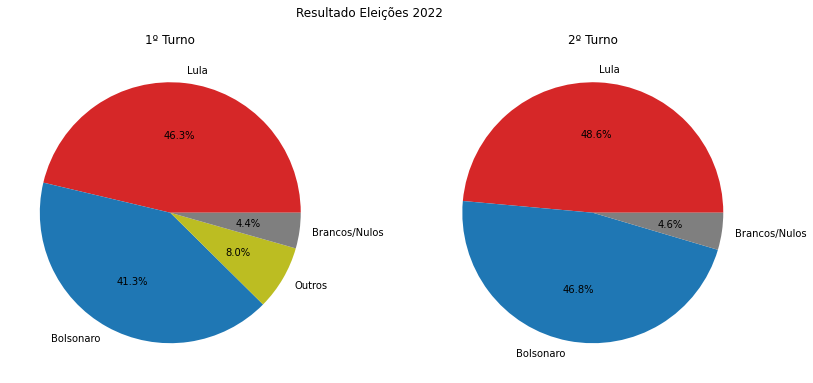

In [117]:
# resultados das eleições 2022 1º e 2º turnos
map_votaveis = {
  "Lula"                                : "Lula",
  "Bolsonaro"                           : "Bolsonaro",
  "Brancos/Nulos"                       : "Brancos/Nulos",
  "Outros"                              : "Outros",

  "LUIZ INÁCIO LULA DA SILVA"           : "Lula",
  "JAIR MESSIAS BOLSONARO"              : "Bolsonaro",

  "VOTO BRANCO"                         : "Brancos/Nulos",
  "VOTO NULO"                           : "Brancos/Nulos",
  
  "CIRO FERREIRA GOMES"                 : "Outros",
  "JOSE MARIA EYMAEL"                   : "Outros",
  "KELMON LUIS DA SILVA SOUZA"          : "Outros",
  "LEONARDO PÉRICLES VIEIRA ROQUE"      : "Outros",
  "LUIZ FELIPE CHAVES D AVILA"          : "Outros",
  "SIMONE NASSAR TEBET"                 : "Outros",
  "SOFIA PADUA MANZANO"                 : "Outros",
  "SORAYA VIEIRA THRONICKE"             : "Outros",
  "VERA LUCIA PEREIRA DA SILVA SALGADO" : "Outros"
}

map_regioes = {
  "AC" : "Norte", 
  "AP" : "Norte", 
  "AM" : "Norte", 
  "RO" : "Norte", 
  "RR" : "Norte", 
  "PA" : "Norte", 
  "TO" : "Norte", 

  "AL" : "Nordeste", 
  "BA" : "Nordeste", 
  "CE" : "Nordeste", 
  "MA" : "Nordeste", 
  "PB" : "Nordeste", 
  "PE" : "Nordeste", 
  "PI" : "Nordeste", 
  "RN" : "Nordeste", 
  "SE" : "Nordeste", 

  "DF" : "Centro-Oeste", 
  "GO" : "Centro-Oeste", 
  "MT" : "Centro-Oeste", 
  "MS" : "Centro-Oeste", 

  "ES" : "Sudeste", 
  "MG" : "Sudeste", 
  "RJ" : "Sudeste", 
  "SP" : "Sudeste", 

  "SC" : "Sul", 
  "PR" : "Sul", 
  "RS" : "Sul", 
}

resultado22_df["NM_VOTAVEL"] = resultado22_df["NM_VOTAVEL"].map(map_votaveis)
resultado22_df["NM_REGIAO"] = resultado22_df["SG_UF"].map(map_regioes) 

resultado22_1turno_df = resultado22_df[ resultado22_df["NR_TURNO"] == 1 ].groupby("NM_VOTAVEL").sum("QT_VOTOS")
resultado22_2turno_df = resultado22_df[ resultado22_df["NR_TURNO"] == 2 ].groupby("NM_VOTAVEL").sum("QT_VOTOS")

resultado22_1turno_df.sort_values("QT_VOTOS", ascending=False, inplace=True)
resultado22_2turno_df.sort_values("QT_VOTOS", ascending=False, inplace=True)

resultado22_1turno_df["PCT_VOTOS"] = resultado22_1turno_df["QT_VOTOS"] / resultado22_1turno_df["QT_VOTOS"].sum() * 100.0
resultado22_2turno_df["PCT_VOTOS"] = resultado22_2turno_df["QT_VOTOS"] / resultado22_1turno_df["QT_VOTOS"].sum() * 100.0

resultado22_1turno_df.drop(["NR_TURNO", "NR_VOTAVEL"], axis=1, inplace=True)
resultado22_2turno_df.drop(["NR_TURNO", "NR_VOTAVEL"], axis=1, inplace=True)

resultado22_1turno_df.reset_index(inplace=True)
resultado22_2turno_df.reset_index(inplace=True)

resultado22_1turno_df["COLOR"] = ["tab:red", "tab:blue", "tab:olive", "tab:gray"]
resultado22_2turno_df["COLOR"] = ["tab:red", "tab:blue", "tab:gray"]

maxy = max([resultado22_1turno_df["QT_VOTOS"].max(), resultado22_2turno_df["QT_VOTOS"].max()]) * 1.05
plt.figure(figsize=(FIG_X, FIG_Y/2))

plt.subplot(121)
plt.pie(
    resultado22_1turno_df["QT_VOTOS"],
    labels=resultado22_1turno_df["NM_VOTAVEL"], 
    colors=resultado22_1turno_df["COLOR"],
    autopct='%1.1f%%'
)
plt.title("1º Turno")

plt.subplot(122)
plt.pie( 
    resultado22_2turno_df["QT_VOTOS"],
    labels=resultado22_2turno_df["NM_VOTAVEL"],
    colors=resultado22_2turno_df["COLOR"],
    autopct='%1.1f%%'
)

plt.title("2º Turno")
plt.suptitle("Resultado Eleições 2022")
plt.show()


## 2ª Pergunta - Como foi o desempenho dos principais candidatos por em cada região?

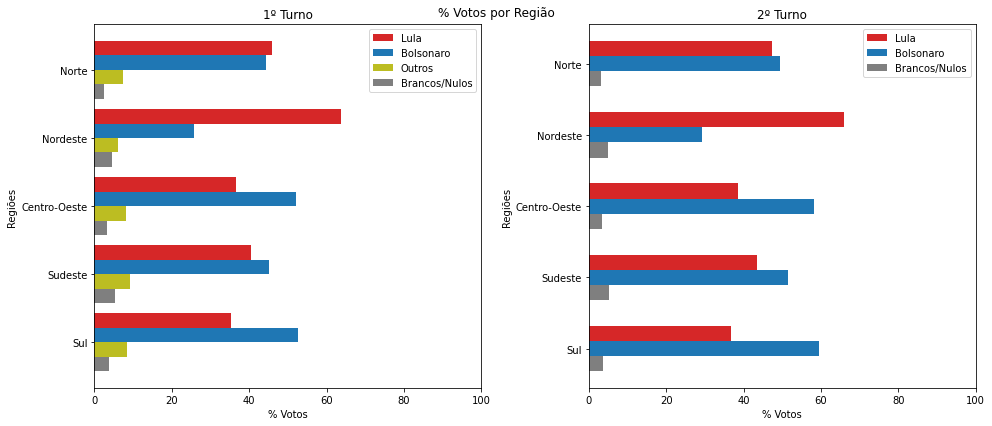

In [118]:
resultado22_1turno_df = resultado22_df[ resultado22_df["NR_TURNO"] == 1 ].groupby(["NM_REGIAO", "NM_VOTAVEL"]).sum("QT_VOTOS")
resultado22_2turno_df = resultado22_df[ resultado22_df["NR_TURNO"] == 2 ].groupby(["NM_REGIAO", "NM_VOTAVEL"]).sum("QT_VOTOS")

resultado22_1turno_df.reset_index(inplace=True)
resultado22_2turno_df.reset_index(inplace=True)

resultado22_1turno_df.drop(["NR_TURNO", "NR_VOTAVEL"], axis=1, inplace=True)
resultado22_2turno_df.drop(["NR_TURNO", "NR_VOTAVEL"], axis=1, inplace=True)

resultado22_1turno_df.sort_values(["NM_REGIAO", "QT_VOTOS"], ascending=(True, True), inplace=True)
resultado22_2turno_df.sort_values(["NM_REGIAO", "QT_VOTOS"], ascending=(True, True), inplace=True)

maxy = 100.0

def tally(df, nm_regiao, nm_votavel):
  return df[ (df["NM_REGIAO"] == nm_regiao) & (df["NM_VOTAVEL"] == nm_votavel) ]["QT_VOTOS"].sum()

def tally_all(df, nm_regiao, nm_votaveis):
  result = []
  for nm_votavel in nm_votaveis:
    t = tally(df, nm_regiao, nm_votavel)
    result.append(t)
  return result

def percentage(tally):
    total = sum(tally)
    return list([ t / total * 100.0 for t in tally ])

# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

def hbar_pct_votos_turno(df, title, subplot_num, turno):
  regioes             = ["Norte", "Nordeste", "Centro-Oeste", "Sudeste", "Sul"]
  labels              = regioes
  
  if turno == 1:
    candidatos          = ["Brancos/Nulos", "Outros", "Bolsonaro", "Lula"]
  else:
    candidatos          = ["Brancos/Nulos", "Bolsonaro", "Lula"]
  
  norte_votos         = tally_all(df, "Norte", candidatos)
  nordeste_votos      = tally_all(df, "Nordeste", candidatos)
  centro_oeste_votos  = tally_all(df, "Centro-Oeste", candidatos)
  sudeste_votos       = tally_all(df, "Sudeste", candidatos)
  sul_votos           = tally_all(df, "Sul", candidatos)

  norte_pcts          = percentage(norte_votos)
  nordeste_pcts       = percentage(nordeste_votos)
  centro_oeste_pcts   = percentage(centro_oeste_votos)
  sudeste_pcts        = percentage(sudeste_votos)
  sul_pcts            = percentage(sul_votos)

  if turno == 1:
    brancos_idx         = 0
    outros_idx          = 1
    bolsonaro_idx       = 2
    lula_idx            = 3
  else:
    brancos_idx         = 0
    bolsonaro_idx       = 1
    lula_idx            = 2

  brancos_nulos_pcts  = [ norte_pcts[brancos_idx],   nordeste_pcts[brancos_idx],   centro_oeste_pcts[brancos_idx],   sudeste_pcts[brancos_idx],   sul_pcts[brancos_idx]   ] 
  bolsonaro_pcts      = [ norte_pcts[bolsonaro_idx], nordeste_pcts[bolsonaro_idx], centro_oeste_pcts[bolsonaro_idx], sudeste_pcts[bolsonaro_idx], sul_pcts[bolsonaro_idx] ] 
  lula_pcts           = [ norte_pcts[lula_idx],      nordeste_pcts[lula_idx],      centro_oeste_pcts[lula_idx],      sudeste_pcts[lula_idx],      sul_pcts[lula_idx]      ] 
  if turno == 1:
    outros_pcts       = [ norte_pcts[outros_idx],    nordeste_pcts[outros_idx],    centro_oeste_pcts[outros_idx],    sudeste_pcts[outros_idx],    sul_pcts[outros_idx]    ] 

  plt.subplot(subplot_num)

  x                 = np.arange(len(labels))
  width             = 0.85

  if turno == 1:
    rects_lula      = plt.barh(x + (width / 4) * -1.5, lula_pcts,          width/4, label="Lula",          color="tab:red")
    rects_bolsonaro = plt.barh(x + (width / 4) * -0.5, bolsonaro_pcts,     width/4, label="Bolsonaro",     color="tab:blue")
    rects_outros    = plt.barh(x + (width / 4) * 0.5, outros_pcts,        width/4, label="Outros",        color="tab:olive")
    rects_brancos   = plt.barh(x + (width / 4) * 1.5, brancos_nulos_pcts, width/4, label="Brancos/Nulos", color="tab:gray")
  else:
    rects_lula      = plt.barh(x + (width / 4) * -1, lula_pcts,          width/4, label="Lula",          color="tab:red")
    rects_bolsonaro = plt.barh(x + (width / 4) * 0, bolsonaro_pcts,     width/4, label="Bolsonaro",     color="tab:blue")
    rects_brancos   = plt.barh(x + (width / 4) * 1, brancos_nulos_pcts, width/4, label="Brancos/Nulos", color="tab:gray")
    
  ax = plt.gca()
  ax.invert_yaxis()
  ax.set_ylabel("Regiões")
  ax.set_xlabel("% Votos")
  ax.set_yticks(x)
  ax.set_yticklabels(labels)
  ax.set_xlim((0, 100))
  ax.legend()
  plt.title(title)


plt.figure(figsize=(FIG_X, FIG_Y/2))
hbar_pct_votos_turno(resultado22_1turno_df, "1º Turno", 121, 1)
hbar_pct_votos_turno(resultado22_2turno_df, "2º Turno", 122, 2)
plt.suptitle("% Votos por Região")
plt.tight_layout()
plt.show()

del resultado22_1turno_df
del resultado22_2turno_df


## 3ª Pergunta - Como o eleitorado está distribuído nas regiões do país?

<ipython-input-119-20c83da296fe>:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(plotnum)


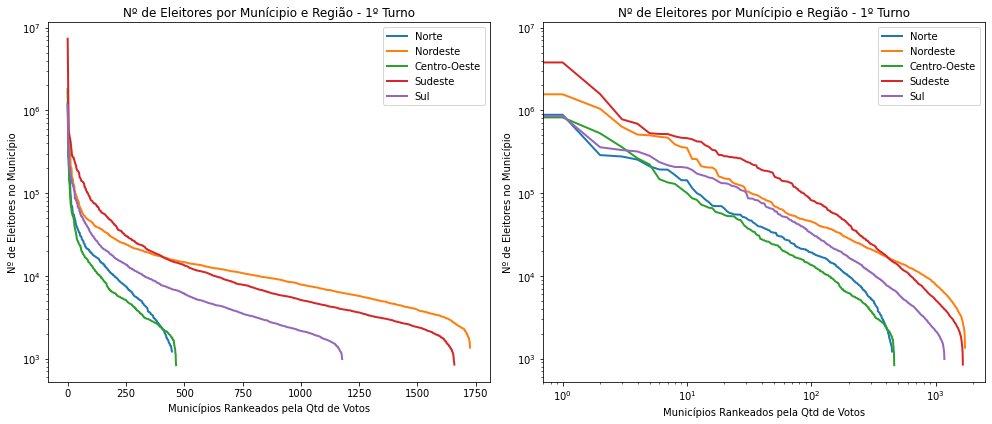

In [119]:
regioes = ["Norte", "Nordeste", "Centro-Oeste", "Sudeste", "Sul" ]
labels = ["10^0", "10^1", "10^2", "10^3", "10^4", "10^5", "10^6", "10^7", "10^8"]
df = resultado22_df.groupby(["NM_REGIAO", "NM_MUNICIPIO", "NR_TURNO"]).sum("QT_VOTOS")
df.reset_index(inplace=True)
# df.info()

dados_1t = {
    "Norte"         : [],
    "Nordeste"      : [],
    "Centro-Oeste"  : [],
    "Sudeste"       : [],
    "Sul"           : [],
    "Todos"         : []
}

dados_2t = {
    "Norte"         : [],
    "Nordeste"      : [],
    "Centro-Oeste"  : [],
    "Sudeste"       : [],
    "Sul"           : [],
    "Todos"         : []
}

# preenchendo os dados
for row in df.itertuples():
  regiao  = row.NM_REGIAO
  turno   = row.NR_TURNO
  votos   = row.QT_VOTOS
  dados   = dados_1t if turno == 1 else dados_2t
  dados[regiao].append(votos)
  dados["Todos"].append(votos)


def plot_eleitores_regiao(plotnum, data, regiao, label, title, logy=True, logx=False):
  plt.subplot(plotnum)
  data = sorted(data[regiao], reverse=True)
  x = range(len(data))
  y = data
  ax = plt.gca()
  ax.plot(x, y, linewidth=2.0, label=label)
  if logy:
    ax.set_yscale("log")
  if logx:
    ax.set_xscale("log")
  ax.set_xlabel("Municípios Rankeados pela Qtd de Votos")
  ax.set_ylabel("Nº de Eleitores no Município")
  ax.set_title(title)
  ax.legend()

plt.figure(figsize=(FIG_X, FIG_Y/2))

plotnum = 121
dados = dados_1t
title = "Nº de Eleitores por Munícipio e Região - 1º Turno"
plot_eleitores_regiao(plotnum, dados, "Norte", "Norte", title)
plot_eleitores_regiao(plotnum, dados, "Nordeste", "Nordeste", title)
plot_eleitores_regiao(plotnum, dados, "Centro-Oeste", "Centro-Oeste", title)
plot_eleitores_regiao(plotnum, dados, "Sudeste", "Sudeste", title)
plot_eleitores_regiao(plotnum, dados, "Sul", "Sul", title)

plotnum = 122
dados = dados_1t
title = "Nº de Eleitores por Munícipio e Região - 1º Turno"
plot_eleitores_regiao(plotnum, dados, "Norte", "Norte", title, logx=True)
plot_eleitores_regiao(plotnum, dados, "Nordeste", "Nordeste", title, logx=True)
plot_eleitores_regiao(plotnum, dados, "Centro-Oeste", "Centro-Oeste", title, logx=True)
plot_eleitores_regiao(plotnum, dados, "Sudeste", "Sudeste", title, logx=True)
plot_eleitores_regiao(plotnum, dados, "Sul", "Sul", title, logx=True)

# plot_eleitores_regiao(121, dados_1t, "Todos", "Todos - 1º Turno")

# plot_eleitores_regiao(121, dados_2t, "Nordeste", "Sul - 2º Turno")
plt.tight_layout()
plt.show()


## 4ª Pergunta - Como foi o desempenho dos principais candidatos em áreas de maior e menor densidade demográfica em cada região?

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10954 entries, 134 to 9237
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   NM_REGIAO      10954 non-null  object 
 1   NM_MUNICIPIO   10954 non-null  object 
 2   NR_TURNO       10954 non-null  int64  
 3   Bolsonaro      10954 non-null  float64
 4   Brancos/Nulos  10954 non-null  float64
 5   Lula           10954 non-null  float64
 6   Outros         10954 non-null  float64
 7   Todos          10954 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 770.2+ KB


<ipython-input-120-f5f0ae91bcf8>:43: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(nrows, ncols, idx)


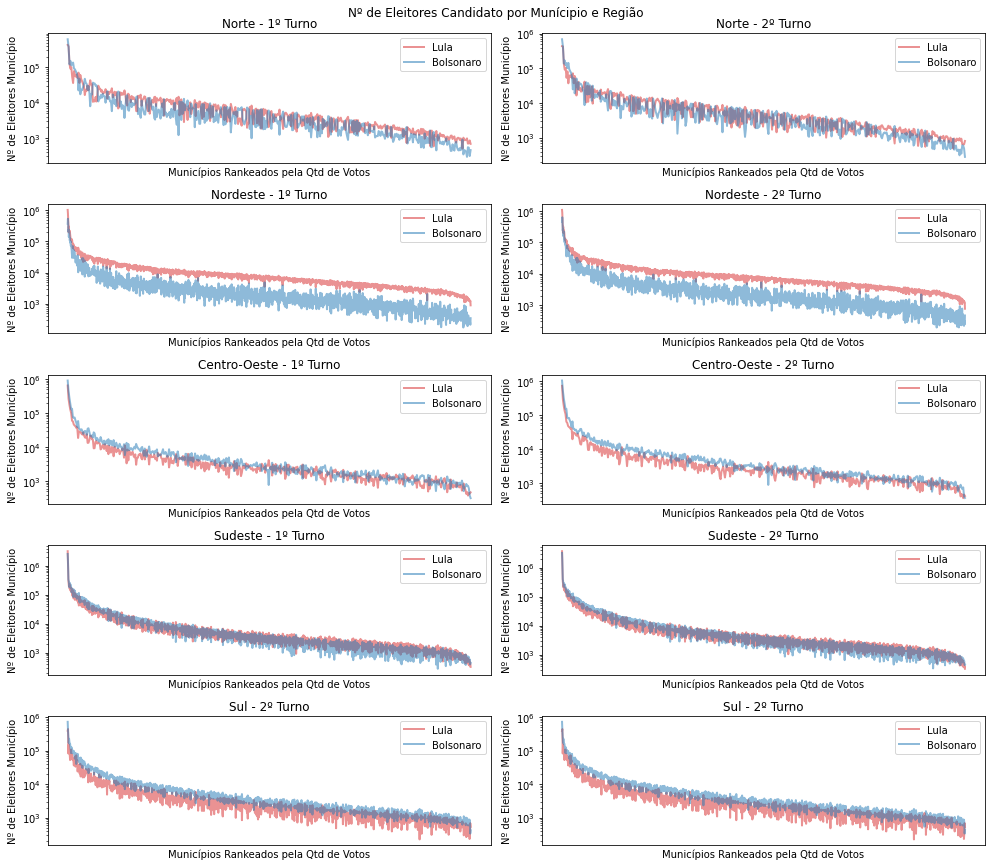

In [120]:
regioes = ["Norte", "Nordeste", "Centro-Oeste", "Sudeste", "Sul" ]
df = resultado22_df.groupby(["NM_REGIAO", "NM_MUNICIPIO", "NR_TURNO", "NM_VOTAVEL"]).sum("QT_VOTOS")
df.reset_index(inplace=True)
df = df.pivot(index=["NM_REGIAO", "NM_MUNICIPIO", "NR_TURNO"], columns="NM_VOTAVEL", values="QT_VOTOS")
df.reset_index(inplace=True)
df["Outros"].fillna(value=0, inplace=True)
df["Todos"] = df["Lula"] + df["Bolsonaro"] + df["Outros"] + df["Brancos/Nulos"]
df.sort_values(["NM_REGIAO", "NR_TURNO", "Todos"], inplace=True, ascending=[True, True, False])
# df.head(100)
df.info()

dados_lula_1t       = { "Norte": [], "Nordeste": [], "Centro-Oeste": [], "Sudeste": [], "Sul": [] }
dados_lula_2t       = { "Norte": [], "Nordeste": [], "Centro-Oeste": [], "Sudeste": [], "Sul": [] }
dados_bolsonaro_1t  = { "Norte": [], "Nordeste": [], "Centro-Oeste": [], "Sudeste": [], "Sul": [] }
dados_bolsonaro_2t  = { "Norte": [], "Nordeste": [], "Centro-Oeste": [], "Sudeste": [], "Sul": [] }
dados_outros_1t     = { "Norte": [], "Nordeste": [], "Centro-Oeste": [], "Sudeste": [], "Sul": [] }
dados_brancos_1t    = { "Norte": [], "Nordeste": [], "Centro-Oeste": [], "Sudeste": [], "Sul": [] }
dados_brancos_2t    = { "Norte": [], "Nordeste": [], "Centro-Oeste": [], "Sudeste": [], "Sul": [] }


# preenchendo os dados
for row in df.itertuples():
  regiao    = row.NM_REGIAO
  turno     = row.NR_TURNO
  bolsonaro = row.Bolsonaro
  lula      = row.Lula
  outros    = row.Outros
  brancos   = row._5 # Brancos/Nulos
  todos     = row.Todos  
  
  if turno == 1:
    dados_lula_1t[regiao].append(lula)
    dados_bolsonaro_1t[regiao].append(bolsonaro)
    dados_outros_1t[regiao].append(outros)
    dados_brancos_1t[regiao].append(brancos)
  else:
    dados_lula_2t[regiao].append(lula)
    dados_bolsonaro_2t[regiao].append(bolsonaro)
    dados_brancos_2t[regiao].append(brancos)

def plot_eleitores_regiao(plotnum, data, regiao, label, title, logy=True, logx=False, **kwargs):
  nrows, ncols, idx = plotnum
  plt.subplot(nrows, ncols, idx)
  data = data[ regiao ]
  x = range(len(data))
  y = data
  ax = plt.gca()
  ax.plot(x, y, linewidth=2.0, label=label, alpha=0.5, **kwargs)
  if logy:
    ax.set_yscale("log")
  if logx:
    ax.set_xscale("log")
  ax.set_xlabel("Municípios Rankeados pela Qtd de Votos")
  ax.set_ylabel("Nº de Eleitores Município")

  ax.tick_params(
      axis='x',          # changes apply to the x-axis
      which='both',      # both major and minor ticks are affected
      bottom=False,      # ticks along the bottom edge are off
      top=False,         # ticks along the top edge are off
      labelbottom=False) # labels along the bottom edge are off

  ax.set_title(title)
  ax.legend(facecolor="white")

def plot_delta(plotnum, data_lula, data_bolsonaro, regiao, **kwargs):
  nrows, ncols, idx = plotnum
  plt.subplot(nrows, ncols, idx)
  data = np.array(data_lula[ regiao ]) > np.array(data_bolsonaro[ regiao ])
  x = range(len(data))
  y = data
  ax = plt.gca()
  ax = ax.twinx()
  ax.step(x, y, linewidth=0.5, color="tab:gray", alpha=0.2, **kwargs)
  ax.tick_params(
      axis='x',          # changes apply to the x-axis
      which='both',      # both major and minor ticks are affected
      bottom=False,      # ticks along the bottom edge are off
      top=False,         # ticks along the top edge are off
      labelbottom=False) # labels along the bottom edge are off

  ax.tick_params(
      axis='y',          # changes apply to the y-axis
      which='both',      # both major and minor ticks are affected
      right=False,       # ticks along the bottom edge are off
      labelright=False) # labels along the bottom edge are off


plt.figure(figsize=(FIG_X, FIG_Y))
nrow = 5
ncols = 2

plotnum = (nrow, ncols, 1)
title = "Norte - 1º Turno"
plot_eleitores_regiao(plotnum, dados_lula_1t, "Norte", "Lula", title, color="tab:red")
plot_eleitores_regiao(plotnum, dados_bolsonaro_1t, "Norte", "Bolsonaro", title, color="tab:blue")
# plot_eleitores_regiao(plotnum, dados_outros_1t, "Norte", "Outros", title, color="tab:olive")
# plot_eleitores_regiao(plotnum, dados_brancos_1t, "Norte", "Brancos/Nulos", title, color="tab:gray")
# plot_delta(plotnum, dados_lula_1t, dados_bolsonaro_1t, "Norte")


plotnum = (nrow, ncols, 2)
title = "Norte - 2º Turno"
plot_eleitores_regiao(plotnum, dados_lula_2t, "Norte", "Lula", title, color="tab:red")
plot_eleitores_regiao(plotnum, dados_bolsonaro_2t, "Norte", "Bolsonaro", title, color="tab:blue")
# plot_eleitores_regiao(plotnum, dados_brancos_2t, "Norte", "Brancos/Nulos", title, color="tab:gray")
# plot_delta(plotnum, dados_lula_2t, dados_bolsonaro_2t, "Norte")


plotnum = (nrow, ncols, 3)
title = "Nordeste - 1º Turno"
plot_eleitores_regiao(plotnum, dados_lula_1t, "Nordeste", "Lula", title, color="tab:red")
plot_eleitores_regiao(plotnum, dados_bolsonaro_1t, "Nordeste", "Bolsonaro", title, color="tab:blue")
# plot_eleitores_regiao(plotnum, dados_outros_1t, "Nordeste", "Outros", title, color="tab:olive")
# plot_eleitores_regiao(plotnum, dados_brancos_1t, "Nordeste", "Brancos/Nulos", title, color="tab:gray")
# plot_delta(plotnum, dados_lula_1t, dados_bolsonaro_1t, "Nordeste")


plotnum = (nrow, ncols, 4)
title = "Nordeste - 2º Turno"
plot_eleitores_regiao(plotnum, dados_lula_2t, "Nordeste", "Lula", title, color="tab:red")
plot_eleitores_regiao(plotnum, dados_bolsonaro_2t, "Nordeste", "Bolsonaro", title, color="tab:blue")
# plot_eleitores_regiao(plotnum, dados_brancos_2t, "Nordeste", "Brancos/Nulos", title, color="tab:gray")
# plot_delta(plotnum, dados_lula_2t, dados_bolsonaro_2t, "Nordeste")

plotnum = (nrow, ncols, 5)
title = "Centro-Oeste - 1º Turno"
plot_eleitores_regiao(plotnum, dados_lula_1t, "Centro-Oeste", "Lula", title, color="tab:red")
plot_eleitores_regiao(plotnum, dados_bolsonaro_1t, "Centro-Oeste", "Bolsonaro", title, color="tab:blue")
# plot_eleitores_regiao(plotnum, dados_outros_1t, "Centro-Oeste", "Outros", title, color="tab:olive")
# plot_eleitores_regiao(plotnum, dados_brancos_1t, "Centro-Oeste", "Brancos/Nulos", title, color="tab:gray")
# plot_delta(plotnum, dados_lula_1t, dados_bolsonaro_1t, "Centro-Oeste")

plotnum = (nrow, ncols, 6)
title = "Centro-Oeste - 2º Turno"
plot_eleitores_regiao(plotnum, dados_lula_2t, "Centro-Oeste", "Lula", title, color="tab:red")
plot_eleitores_regiao(plotnum, dados_bolsonaro_2t, "Centro-Oeste", "Bolsonaro", title, color="tab:blue")
# plot_eleitores_regiao(plotnum, dados_brancos_2t, "Centro-Oeste", "Brancos/Nulos", title, color="tab:gray")
# plot_delta(plotnum, dados_lula_2t, dados_bolsonaro_2t, "Centro-Oeste")

plotnum = (nrow, ncols, 7)
title = "Sudeste - 1º Turno"
plot_eleitores_regiao(plotnum, dados_lula_1t, "Sudeste", "Lula", title, color="tab:red")
plot_eleitores_regiao(plotnum, dados_bolsonaro_1t, "Sudeste", "Bolsonaro", title, color="tab:blue")
# plot_eleitores_regiao(plotnum, dados_outros_1t, "Sudeste", "Outros", title, color="tab:olive")
# plot_eleitores_regiao(plotnum, dados_brancos_1t, "Sudeste", "Brancos/Nulos", title, color="tab:gray")
# plot_delta(plotnum, dados_lula_1t, dados_bolsonaro_1t, "Sudeste")

plotnum = (nrow, ncols, 8)
title = "Sudeste - 2º Turno"
plot_eleitores_regiao(plotnum, dados_lula_2t, "Sudeste", "Lula", title, color="tab:red")
plot_eleitores_regiao(plotnum, dados_bolsonaro_2t, "Sudeste", "Bolsonaro", title, color="tab:blue")
# plot_eleitores_regiao(plotnum, dados_brancos_2t, "Sudeste", "Brancos/Nulos", title, color="tab:gray")
# plot_delta(plotnum, dados_lula_2t, dados_bolsonaro_2t, "Sudeste")

plotnum = (nrow, ncols, 9)
title = "Sul - 2º Turno"
plot_eleitores_regiao(plotnum, dados_lula_2t, "Sul", "Lula", title, color="tab:red")
plot_eleitores_regiao(plotnum, dados_bolsonaro_2t, "Sul", "Bolsonaro", title, color="tab:blue")
# plot_eleitores_regiao(plotnum, dados_outros_1t, "Sul", "Outros", title, color="tab:olive")
# plot_eleitores_regiao(plotnum, dados_brancos_1t, "Sul", "Brancos/Nulos", title, color="tab:gray")
# plot_delta(plotnum, dados_lula_1t, dados_bolsonaro_1t, "Sul")

plotnum = (nrow, ncols, 10)
title = "Sul - 2º Turno"
plot_eleitores_regiao(plotnum, dados_lula_2t, "Sul", "Lula", title, color="tab:red")
plot_eleitores_regiao(plotnum, dados_bolsonaro_2t, "Sul", "Bolsonaro", title, color="tab:blue")
# plot_eleitores_regiao(plotnum, dados_brancos_2t, "Sul", "Brancos/Nulos", title, color="tab:gray")
# plot_delta(plotnum, dados_lula_2t, dados_bolsonaro_2t, "Sul")


plt.suptitle("Nº de Eleitores Candidato por Munícipio e Região", y=1.0)
plt.tight_layout()
plt.show()

## 5ª pergunta - Onde situa-se o eleitorado dos 2 principais candidatos nas eleições de 2022?

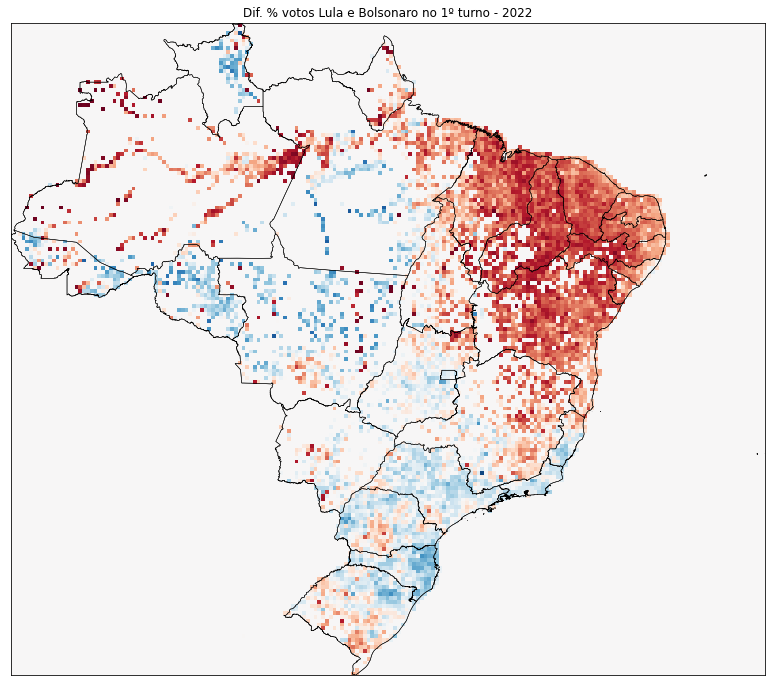

In [121]:
data = lula22_1t_pct - bolsonaro22_1t_pct
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(nth_root(data, 1), cmap="RdBu_r")
plt.title("Dif. % votos Lula e Bolsonaro no 1º turno - 2022")
plt.show()

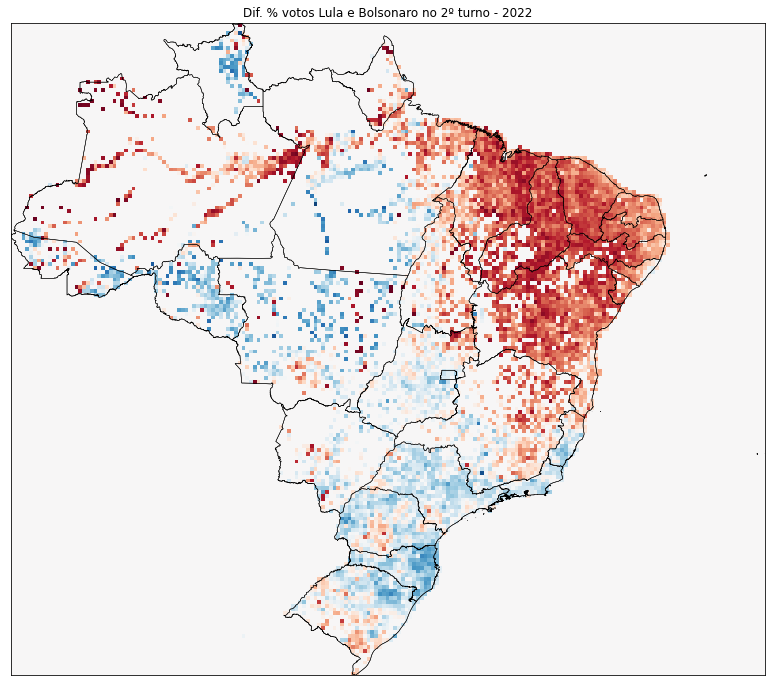

In [122]:
data = lula22_2t_pct - bolsonaro22_2t_pct
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(nth_root(data, 1), cmap="RdBu_r")
plt.title("Dif. % votos Lula e Bolsonaro no 2º turno - 2022")
plt.show()

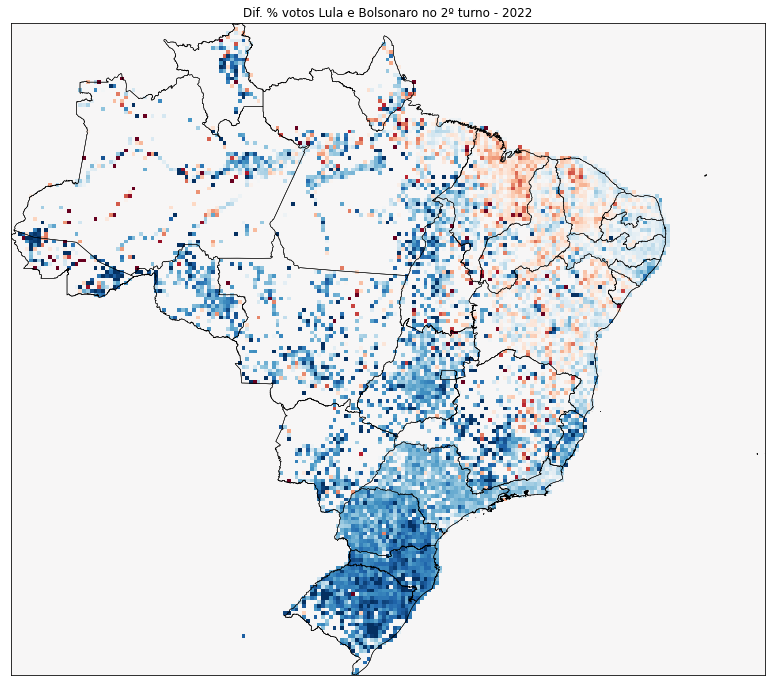

In [123]:
data = (lula22_2t_pct - lula22_1t_pct) - (bolsonaro22_2t_pct - bolsonaro22_1t_pct)
pcts = spatial_histogram(data)
p05 = pcts[ int(0.05 * len(pcts)) ]
p95 = pcts[ int(0.95 * len(pcts)) ] 
vmin, vmax = minmax([p05, p95], symmetrical=True)
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(nth_root(data, 1), cmap="RdBu_r", vmin=vmin, vmax=vmax)
plt.title("Dif. % votos Lula e Bolsonaro no 2º turno - 2022")
plt.show()

**Análise:** O eleitorado de Bolsonaro situa-se majoritariamente nas regiões Sul, Sudeste e Centro-Oeste. Já o eleitorado de Lula localiza-se da região centro norte de Minas e Norte do Espírito Santo e extende-se até o Nordeste do Pará.

O estado de Santa Catarina espacialmente é quase homogeneaemente todo bolsonarista, assim como Rio e São Paulo, mas diferentemente de Santa Catarina, as capitais destes dois últimos estados tiveram um número maior de votos para o candidato do PT.

Surpreendentemente, Paraná e Rio Grande do Sul apresentaram a existência de bolsões em que o apoio ao candidato do PT foi maior.

Pará apresentou uma acentuada regionalização, com sua parte setentrional preferindo o candidato do PT

Visualmente não é possível identificar diferenças significativas na distribuição de votos entre o 1º e o 2º turno.

--- aprofundar ---

## 6ª pergunta - Existe diferença significativa regionalizada no quantitativo de votos no 1º e 2º turnos da eleição de 2022?

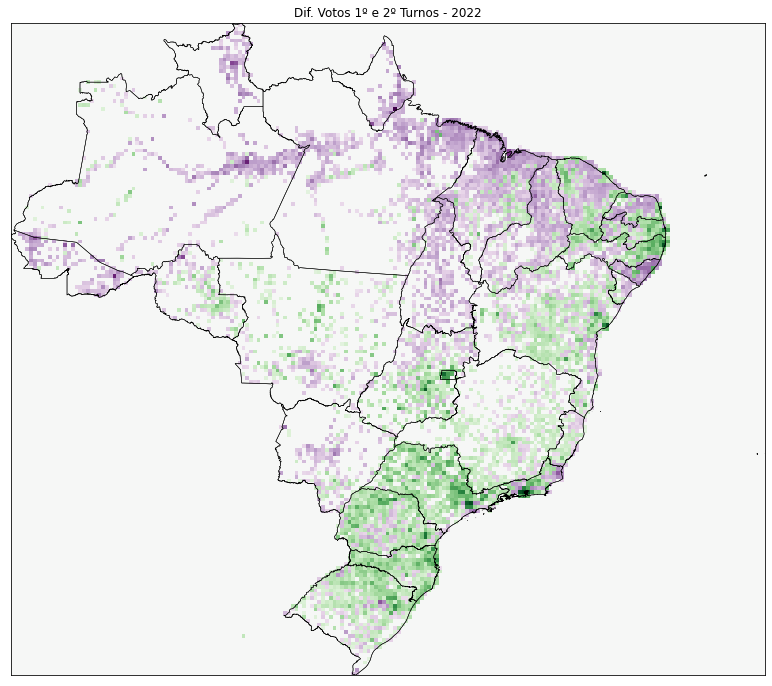

In [124]:
# Pergunta - Como foi o desempenho eleitoral dos principais candidatos no 1º turno da eleição de 2022
data = turno22_2t - turno22_1t
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(nth_root(data), cmap="PRGn")
plt.title("Dif. Votos 1º e 2º Turnos - 2022")
plt.show()

**Análise:** Observa-se que a região Sul e Sudeste apresentaram um significativo aumento no número de votos no 2º turno.

A região nordeste, apesar de apresentar densidade populacional relevante, teve
uma significativa redução no quantitativo de votos registrados no segundo turno.

O estado do Mato Grosso apresenta uma anomalia. Observa-se aumento no quantitativo de votos em áreas de baixíssima densidade populacional. Em áreas
de densidade populacional equivalente, normalmente observa-se a redução do quantitativo de votos no 2º turno.

## 7ª pergunta - Existe diferença significativa regionalizada no quantitativo de votos no 1º e 2º turnos da eleição de 2022?

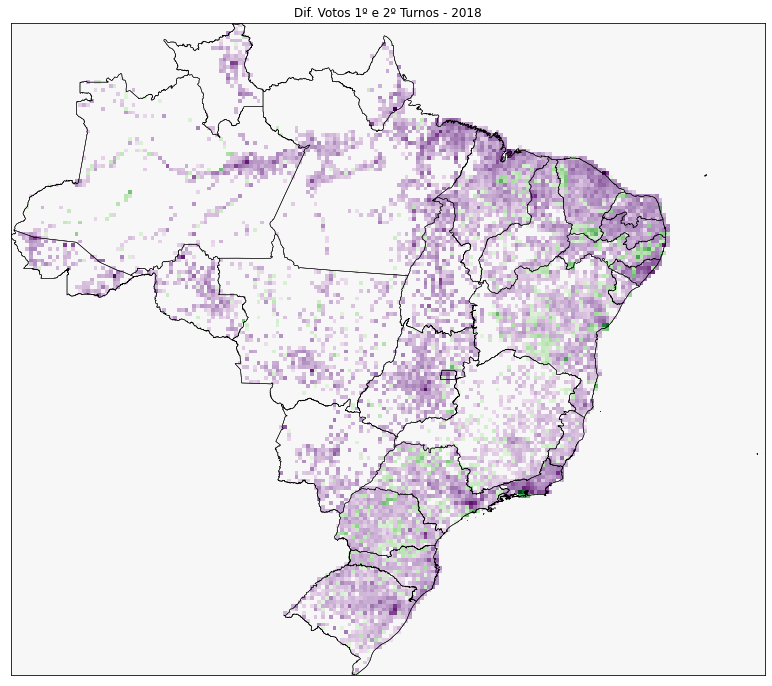

In [125]:
data = turno18_2t - turno18_1t
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(nth_root(data), cmap="PRGn")
plt.title("Dif. Votos 1º e 2º Turnos - 2018")
plt.show()

**Análise:** No cenário eleitoral observado em 2018 observou-se que, de maneira geral, houve uma redução no número de votos no 2º turno em praticamente todas as regiões do país, delineando uma clara mudança no comportamento eleitoral quando comparado com os dados da eleição de 2022

## 8ª pergunta - Em comparação com 2018, onde o Lula/Haddad ganharam ou perderam votos %?

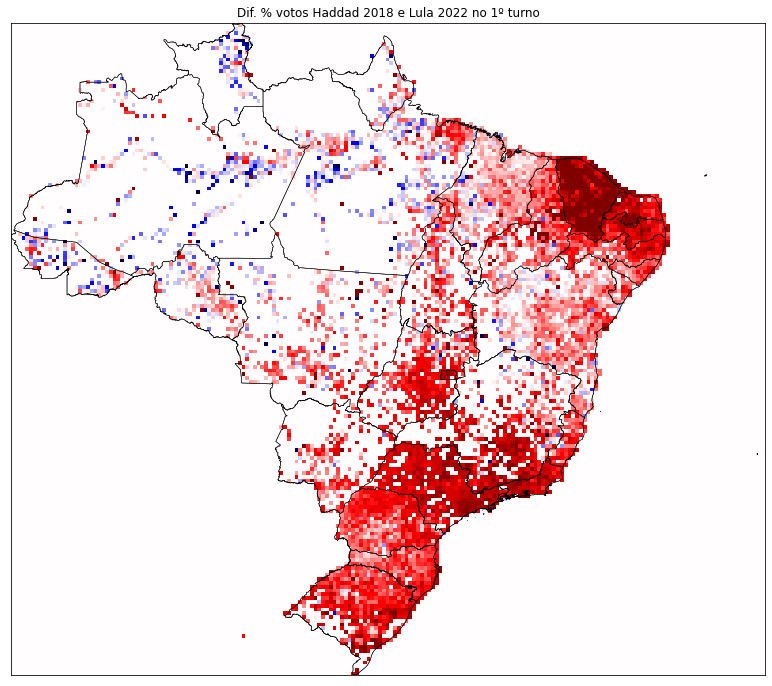

In [126]:
data = lula22_1t_pct - haddad18_1t_pct
pcts = spatial_histogram(data)
p05 = pcts[ int(0.05 * len(pcts)) ]
p95 = pcts[ int(0.95 * len(pcts)) ] 
vmin, vmax = minmax([p05, p95], symmetrical=True)
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(nth_root(data, 1), cmap="seismic", vmin=vmin, vmax=vmax)
plt.title("Dif. % votos Haddad 2018 e Lula 2022 no 1º turno")
plt.show()

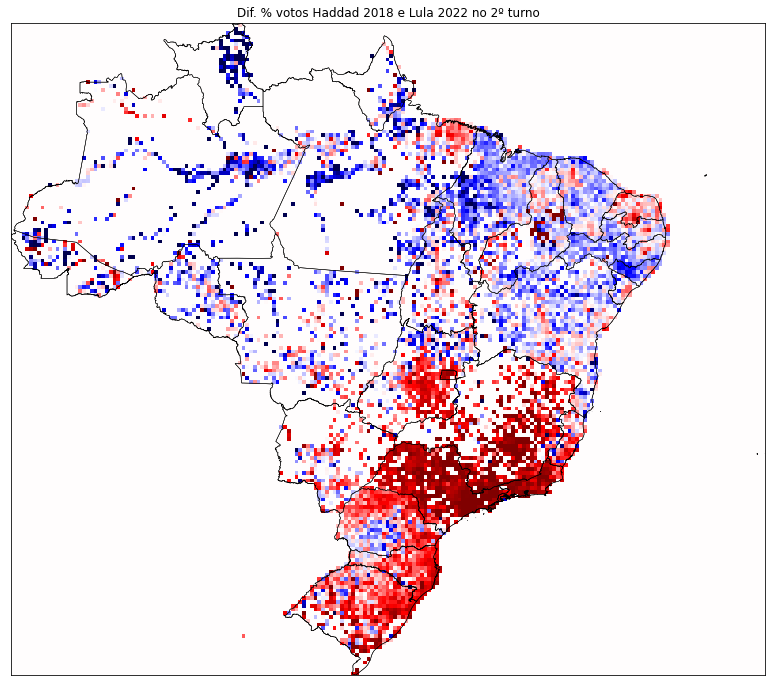

In [127]:
data = lula22_2t_pct - haddad18_2t_pct
pcts = spatial_histogram(data)
p05 = pcts[ int(0.05 * len(pcts)) ]
p95 = pcts[ int(0.95 * len(pcts)) ] 
vmin, vmax = minmax([p05, p95], symmetrical=True)
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(nth_root(data, 1), cmap="seismic", vmin=vmin, vmax=vmax)
plt.title("Dif. % votos Haddad 2018 e Lula 2022 no 2º turno")
plt.show()

**Análise:** De maneira gertal, o candidato Lula em 2022 conseguiu uma maior adesão de eleitores em todos os estados durante o 1º turno quando comparado com Haddad em 2018. Observa-se no entanto que os estados do Norte e Mato Grosso, o candidato Lula perdeu eleitores que eram de Haddad em 2018.

No 2º turno, Lula em 2022 conseguiu angariar votos em Minas, São Paulo, Rio de Janeiro, Paraná, Santa Catarina e Rio Grande do Sul que o candidato Haddad em 2018 não conseguiu obter tal apoio. 

Contudo, percentualmente Lula perdeu percentual de votos em todo o Nordeste que Haddad havia conseguido fidelizar, indicando que, apesar de um resultado expressivo no Nordeste, o Bolsonarismo conseguiu se apropriar de parte destes votos.

Observa-se que no 1º turno de 2018 Haddad teve um desempenho ruim no Ceará, onde o candidato Ciro Gomes tinha uma vantagem. Constatou-se algumas anomalias no Piauí contabilizando mais votos para Lula em 2022 cuja a causa não conseguimos claramente atribuir.

## 9ª pergunta - Em comparação com 2018, onde o Bolsonaro ganhou ou perdeu votos %?

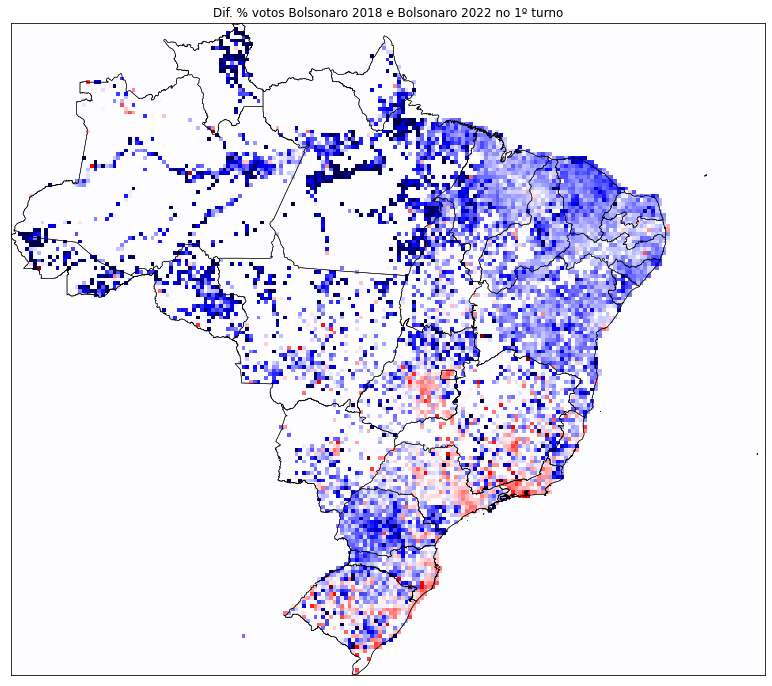

In [128]:
data = nth_root(bolsonaro22_1t_pct - bolsonaro18_1t_pct, 1)
pcts = spatial_histogram(data)
p05 = pcts[ int(0.05 * len(pcts)) ]
p95 = pcts[ int(0.95 * len(pcts)) ] 
vmin, vmax = minmax([p05, p95], symmetrical=True)
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(nth_root(data, 1), cmap="seismic_r", vmin=vmin, vmax=vmax)
plt.title("Dif. % votos Bolsonaro 2018 e Bolsonaro 2022 no 1º turno")
plt.show()

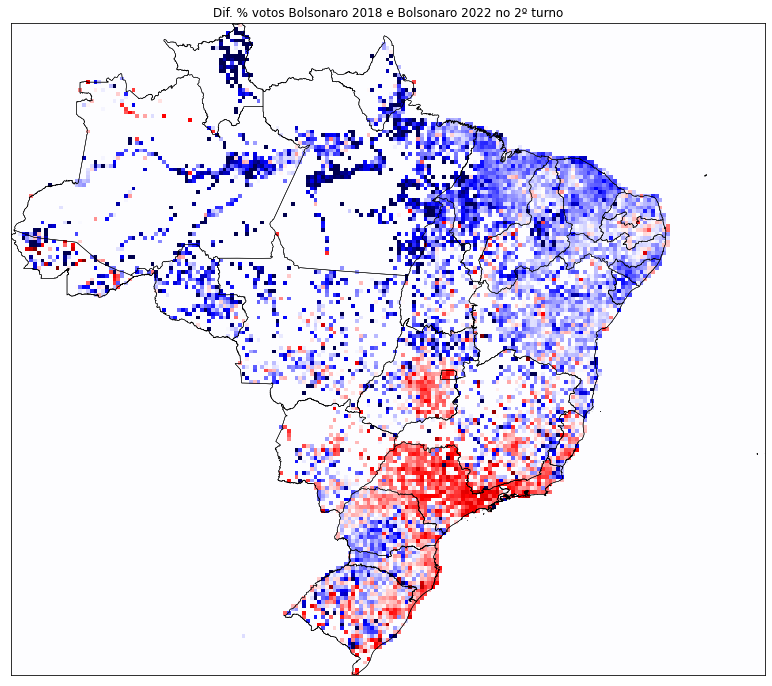

In [129]:
data = bolsonaro22_2t_pct - bolsonaro18_2t_pct
pcts = spatial_histogram(data)
p05 = pcts[ int(0.05 * len(pcts)) ]
p95 = pcts[ int(0.95 * len(pcts)) ] 
vmin, vmax = minmax([p05, p95], symmetrical=True)
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(nth_root(data, 1), cmap="seismic_r", vmin=vmin, vmax=vmax)
plt.title("Dif. % votos Bolsonaro 2018 e Bolsonaro 2022 no 2º turno")
plt.show()

**Análise:** (parece errado... analisar) O candidato Bolsonaro no 1º turno de 2022 conseguiu angariar mais votos percentuais em regiões de elevada densidade demográfica na região Sudeste e também em Goiás, Santa Catarina e Mato Grosso do Sul quando comparado com seu desempenho no 1º turno de 2018, caracterizando o Bolsonarismo em sua origem como um movimento regionalizado que se espalhou para o restante do país à partir do segundo turno da eleição de 2018.

Na comparação dos votos percentuais dos 2º's turnos de 2022 e 2018, observa-se que o fenômeno do Bolsonarismo de fato se espalha para o restante do país e que existe uma diminuição dos votos percentuais de Bolsonaro nas regiões dos estados que atuaram como seu berçário.

## 10ª pergunta - Quais são as regiões com maior percentual de eleitores indecisos?

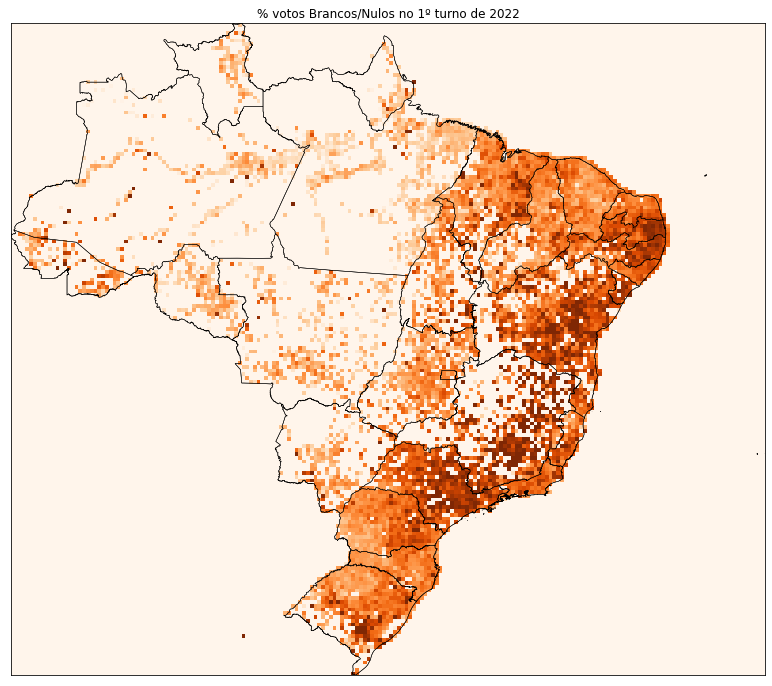

In [135]:
data = brancosnulos22_1t_pct
pcts = spatial_histogram(data)
vmin = 0.0
vmax = pcts[ int(0.95 * len(pcts)) ] 
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(nth_root(data, 1), cmap="Oranges", vmin=vmin, vmax=vmax)
plt.title("% votos Brancos/Nulos no 1º turno de 2022")
plt.show()

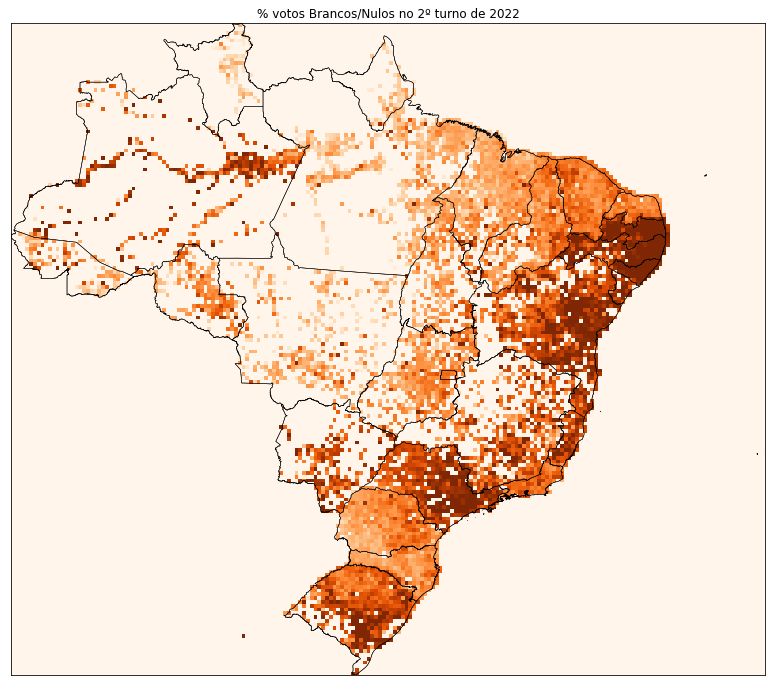

In [131]:
data = brancosnulos22_2t_pct
pcts = spatial_histogram(data)
vmin = 0.0
vmax = pcts[ int(0.9 * len(pcts)) ] 
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(nth_root(data, 1), cmap="Oranges", vmin=vmin, vmax=vmax)
plt.title("% votos Brancos/Nulos no 2º turno de 2022")
plt.show()

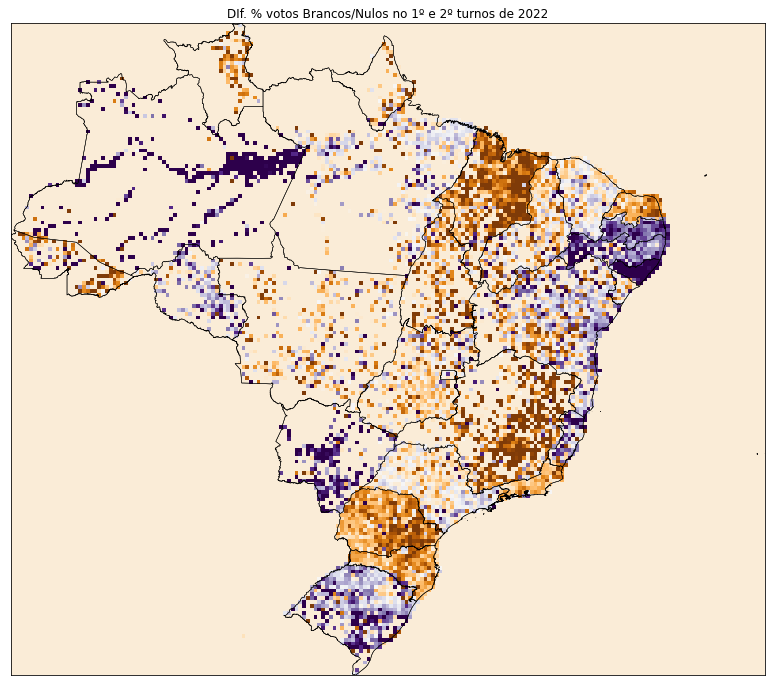

In [132]:
data = brancosnulos22_2t_pct - brancosnulos22_1t_pct
pcts = spatial_histogram(data)
vmin = pcts[ int(0.1 * len(pcts)) ]
vmax = pcts[ int(0.9 * len(pcts)) ] 
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(nth_root(data, 1), cmap="PuOr", vmin=vmin, vmax=vmax)
plt.title("DIf. % votos Brancos/Nulos no 1º e 2º turnos de 2022")
plt.show()

## 11ª pergunta - Houve supressão de votos de algum candidato em alguma região?

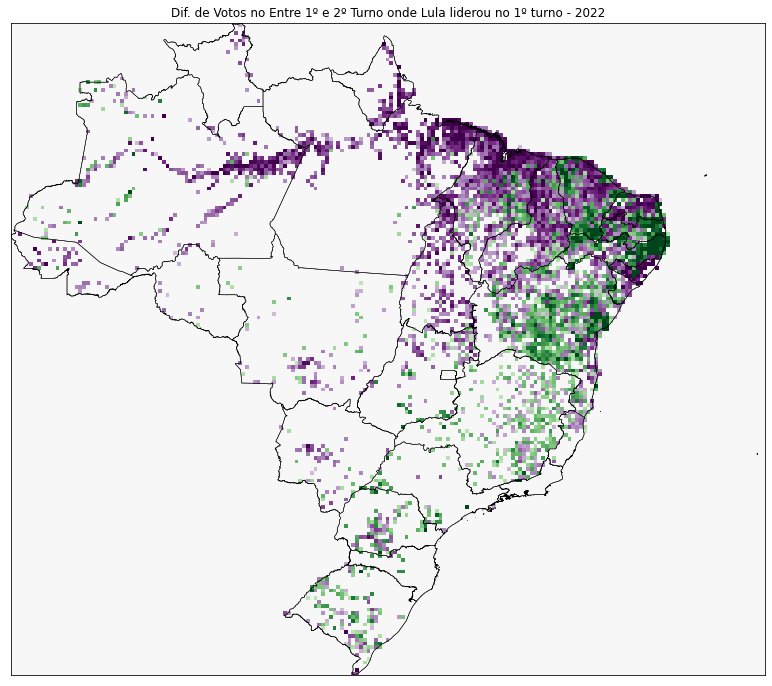

In [133]:
mask_lula = (lula22_1t_pct >= 0.5).astype(float)
# mask_lula = (lula22_1t_pct >= bolsonaro22_1t_pct).astype(float)
data_lula = mask_lula * (turno22_2t - turno22_1t)
pcts = spatial_histogram(data_lula)
p05 = pcts[ int(0.05 * len(pcts)) ]
p95 = pcts[ int(0.95 * len(pcts)) ] 
vmin, vmax = minmax([p05, p95], symmetrical=True)
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(nth_root(data_lula), cmap="PRGn", vmin=nth_root(vmin), vmax=nth_root(vmax))
plt.title("Dif. de Votos no Entre 1º e 2º Turno onde Lula liderou no 1º turno - 2022")
plt.show()


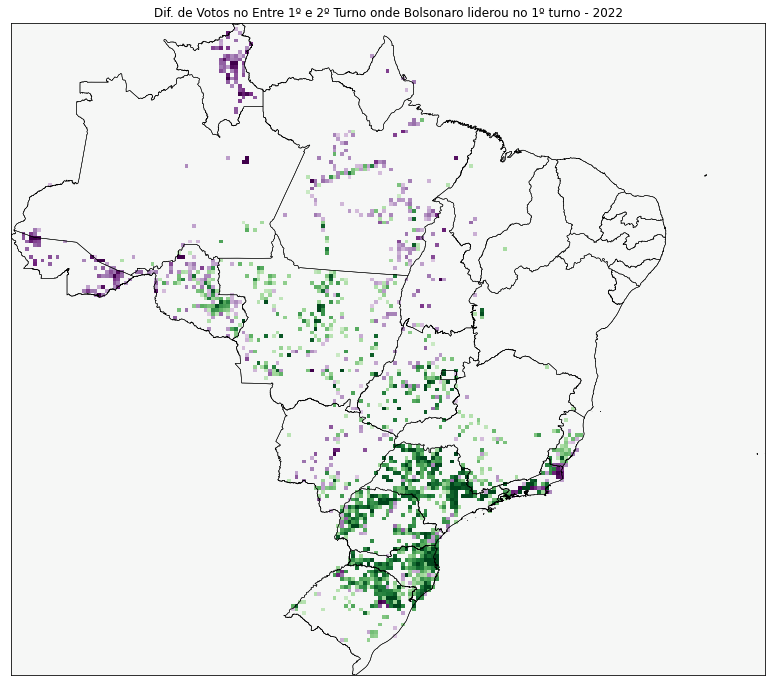

In [134]:
mask_bolsonaro = (bolsonaro22_1t_pct >= 0.5).astype(float)
# mask_bolsonaro = (bolsonaro22_1t_pct >= lula22_1t_pct).astype(float)
data_bolsonaro = mask_bolsonaro * (turno22_2t - turno22_1t)
pcts = spatial_histogram(data_bolsonaro)
p05 = pcts[ int(0.05 * len(pcts)) ]
p95 = pcts[ int(0.95 * len(pcts)) ] 
vmin, vmax = minmax([p05, p95], symmetrical=True)
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(nth_root(data_bolsonaro), cmap="PRGn", vmin=nth_root(vmin), vmax=nth_root(vmax))
plt.title("Dif. de Votos no Entre 1º e 2º Turno onde Bolsonaro liderou no 1º turno - 2022")
plt.show()


**Análise:** Observa-se que o candidato Lula apresentou uma redução concentrada de votos em áreas do Nordeste, mas em áreas de mais baixa densidade demográfica. 